Построение модели C-LSTM на основе дизайна из [статьи](https://arxiv.org/pdf/1511.08630.pdf).
### Key points
* Two main components: convolutional neural network (CNN) and long short- term memory network (LSTM)
#### Preprocessing
*   lower case
#### Padding
*   pad each sentence that has a length less than maxlen/cut extra words at the end of these sentences to reach maxlen when sentence is longer than maxlen
*   padding with UNK
#### Word vectors
*   We initialize word vectors with the publicly avail- able word2vec vectors1 that are pre-trained using about 100B words from the Google News Dataset.
*   The dimensionality of the word vectors is 300.
*   We also initialize the word vector for the unknown words from the uniform distribution [-0.25, 0.25]
* fine-tuning the word vectors
#### Regularization
*   dropout (either to word vectors before feeding the sequence of words into the convolutional layer or to the output of LSTM before the softmax layer)
*   L2 weight regularization (applied to the weight of the softmax layer)
#### CNN
*   one convolutional layer
*   no pooling
*   nonlinear transformation function ReLU
*   filter lengths of 2, 3 and 4 in two cases: a) single convolutional layer with the same filter length, and b) multiple convolutional layers with different lengths of filters in parallel (final is 3)
*   No fully connected layers between CNN and LSTM
#### LSTM
* one layer
*   the logistic sigmoid function, the hyperbolic tangent function, the elementwise multiplication
*   since the number of windows generated from each convolution layer varies when the filter length varies (see L − k + 1 below equation (3)), we cut the window sequence at the end based on the maximum filter length that gives the shortest number of windows
#### Hyperparameters
For SST, we conduct hyperparameter (number of filters, filter length in CNN; memory dimension in LSTM; dropout rate and which layer to apply, etc.) tuning on the validation data in the standard split. For TREC, we hold out 1000 samples from the training dataset for hyperparameter search and train the model using the remaining data.
In our final settings, we only use one convolutional layer and one LSTM layer for both tasks.
*   cross-entropy loss - stochastic gradient descent (SGD) - optimizer RM-Sprop


















In [ ]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import RMSprop
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import gensim
import nltk
nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('../input/dataminingproject2/Fake.csv')
df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
len(df)

23481

Приведем все тексты к нижнему регистру и токенизируем

In [ ]:
def preprocessing(text):
    text = text.lower()
    text = word_tokenize(text)
    return text

In [ ]:
df['tokens'] = df['text'].apply(lambda x: preprocessing(x))

Посмотрим на распределение категорий в данных

In [ ]:
df['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

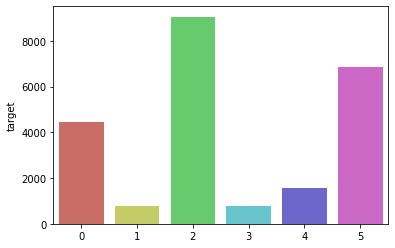

In [ ]:
x = list(df['subject'].unique())
df['target'] = df['subject'].astype('category').cat.codes
sns.barplot(
    x=list(df['target'].unique()), 
    y=df['target'].value_counts(), 
    palette='hls',
    data=df);

Распределение данных по классам неравномерное, что может плохо сказаться на результатах. Как вариант для решения этой проблемы можно обрезать данные по наиболее встречающимся классам, но тогда у нас будет очень мало данных для модели. Оставим все как есть.

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
train_data, val_data = train_test_split(df, test_size=0.2, shuffle=True, random_state=seed, stratify=df['target'])

In [ ]:
vocab = Counter()
for text in tqdm(df['tokens']):
    vocab.update(text)
print('всего уникальных символов:', len(vocab))

  0%|          | 0/23481 [00:00<?, ?it/s]

всего уникальных символов: 181384


In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 3:
        filtered_vocab.add(word)
print('уникальных символов, вcтретившихся больше 3 раз:', len(filtered_vocab))

уникальных символов, вcтретившихся больше 3 раз: 48324


In [ ]:
word2id = {'UNK':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [ ]:
MAX_LEN = train_data['tokens'].str.len().max()
MAX_LEN

9938

тк значение максимальной длины очень большое и не влезет в коллаб, возьмем число поменьше.

In [ ]:
MAX_LEN = 600

#### Модель word2vec

In [ ]:
! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-29 14:23:12--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.202.136
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.202.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.6MB/s    in 98s     

2021-12-29 14:24:52 (16.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
from gensim import models

w = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
weights = np.zeros((len(word2id), 300))
for word, num in word2id.items():
    try:
        weights[num] = w[word]
    except KeyError:
        weights[num] = np.random.uniform(-0.25, 0.25, 300)
weights = torch.FloatTensor(weights)

#### Dataset & DataLoader

In [ ]:
class NewsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['tokens'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['target'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index]
        ids = torch.LongTensor([self.word2id[token] if token in self.word2id
                                else self.word2id['UNK'] for token in tokens][:MAX_LEN])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = torch.vstack([F.pad(seq, pad=(0, MAX_LEN - seq.shape[0]),
                                       mode='constant', value=0) for seq in ids])
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.LongTensor(y).T[0].to(self.device)
      return padded_ids, y

In [ ]:
train_dataset = NewsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=128)

In [ ]:
val_dataset = NewsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler, batch_size=128)

#### Модель

In [ ]:
class C_LSTM(nn.Module):
    
    def __init__(self, vocab_size, max_len=600, filter_sizes=[2, 3, 4], 
                 filters_num=150, memory_dim=150, dropout_rate=0.5,
                 dropout_input=False, dropout_lstm=True):
        super().__init__()

        self.vocab_size = vocab_size
        self.max_len = max_len
        self.filter_sizes = filter_sizes
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.dropout_input = dropout_input
        self.dropout_lstm = dropout_lstm
  
        # CNN
        convs = []
        for size in filter_sizes:
            conv = nn.Conv1d(in_channels=300, out_channels=filters_num, kernel_size=size, padding='valid')
            convs.append(conv)
        self.convs = nn.ModuleList(convs)

        # LSTM
        self.lstm = nn.LSTM(input_size=len(filter_sizes)*filters_num, hidden_size=memory_dim, num_layers= 1, batch_first=True)

        # activations
        self.dropout = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(memory_dim, 6)
        self.out = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.transpose(1, 2)
        if self.dropout_input:
            embedded = self.dropout(embedded)

        max_feature = self.max_len - max(self.filter_sizes) + 1

        # CNN
        cnn_outputs = []
        for conv in self.convs:
            layer = conv(embedded)
            layer = self.relu(layer)
            layer = layer[:, :, :max_feature]
            cnn_outputs.append(layer)
        if len(self.filter_sizes) > 1:
            rnn_input = torch.cat(cnn_outputs, 1)
        else:
            rnn_input = layer

        # LSTM
        _, (hidden_state, _) = self.lstm(rnn_input.transpose(1, 2))
        if self.dropout_lstm:
            embedded = self.dropout(hidden_state)
        output = torch.squeeze(hidden_state, 0)
        output = self.linear(output)
        logit = self.out(output)

        return logit

In [ ]:
def train(model, optimizer, criterion, epoch):
    progress_bar = tqdm(total=len(train_iterator.dataset), desc='Epoch {}'.format(epoch + 1))
    epoch_losses = []
    epoch_metrics = []

    model.train()

    for i, (texts, ys) in enumerate(train_iterator):
        optimizer.zero_grad() 
        preds = model(texts)
        loss = criterion(preds, ys)  
        loss.backward() 
        optimizer.step() 
        epoch_losses.append(loss.item())
        batch_metrics = accuracy(preds.argmax(1).long(), ys.long(), average='weighted', num_classes=6, ignore_index=0)
        epoch_metrics.append(batch_metrics.cpu().numpy())
        if not (i + 1) % int(len(train_iterator)/5):
            print(f'Train loss: {np.mean(epoch_losses)}, Train metric: {np.mean(epoch_metrics)}')  
        progress_bar.update(texts.shape[0])
    return np.mean(epoch_losses), np.mean(epoch_metrics)

In [ ]:
def evaluate(model, criterion):
    epoch_losses = []
    epoch_metrics = []
    
    model.eval()

    with torch.no_grad():
        for i, (texts, ys) in enumerate(val_iterator):   
            preds = model(texts)
            loss = criterion(preds, ys) 
            epoch_losses.append(loss.item())
            batch_metrics = accuracy(preds.argmax(1).long(), ys.long(), average='weighted', num_classes=6, ignore_index=0)
            epoch_metrics.append(batch_metrics.cpu().numpy())
            if not (i + 1) % int(len(val_iterator)/5):
              print(f'Val loss: {np.mean(epoch_losses)}, Val metric: {np.mean(epoch_metrics)}')
        
    return np.mean(epoch_losses), np.mean(epoch_metrics)

Запустим модель на дефолтных параметрах из статьи

In [ ]:
model = C_LSTM(len(word2id), max_len=600, filter_sizes=[2, 3, 4],
               filters_num=150, memory_dim=150, dropout_rate=0.5, 
               dropout_input=False, dropout_lstm=True)
model = model.to(DEVICE)
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

In [ ]:
epochs = 5
train_losses = []
train_accuracy = []
eval_losses = []
eval_accuracy = []

for epoch in range(epochs):
    print(f'\nstarting Epoch {epoch+1}')
    print('Training...')
    epoch_loss, epoch_metrics = train(model, optimizer, criterion, epoch)
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_metrics)
    print('\nEvaluating...')
    epoch_loss_eval, epoch_metrics_eval = evaluate(model, criterion)
    eval_losses.append(epoch_loss_eval)
    eval_accuracy.append(epoch_metrics_eval)


starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.661909321258808, Train metric: 0.38860198855400085
Train loss: 1.6483555580007618, Train metric: 0.4010831117630005
Train loss: 1.64727390223536, Train metric: 0.40271905064582825
Train loss: 1.639354592767255, Train metric: 0.4147557318210602
Train loss: 1.6100383890086207, Train metric: 0.4571864604949951

Evaluating...
Val loss: 1.4276736293520247, Val metric: 0.6767102479934692
Val loss: 1.4475679908479964, Val metric: 0.6594423651695251
Val loss: 1.4477053085962932, Val metric: 0.6587017774581909
Val loss: 1.444147331374032, Val metric: 0.6624695062637329
Val loss: 1.4433057274137224, Val metric: 0.6658730506896973

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4398739214601188, Train metric: 0.656403660774231
Train loss: 1.4374113370632302, Train metric: 0.6573664546012878
Train loss: 1.4299937856608425, Train metric: 0.6628861427307129
Train loss: 1.4275893712865895, Train metric: 0.6648818254470825
Train loss: 1.4253889322280884, Train metric: 0.6660909056663513

Evaluating...
Val loss: 1.3944612741470337, Val metric: 0.6896910667419434
Val loss: 1.4148361342293876, Val metric: 0.6737874150276184
Val loss: 1.415256381034851, Val metric: 0.6735292077064514
Val loss: 1.4125662020274572, Val metric: 0.6733722686767578
Val loss: 1.4126907791410173, Val metric: 0.6745800971984863

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4090258664098279, Train metric: 0.6811118721961975
Train loss: 1.4076911560420333, Train metric: 0.6804779171943665
Train loss: 1.4109245949778064, Train metric: 0.6760160326957703
Train loss: 1.411433451134583, Train metric: 0.6748901605606079
Train loss: 1.4102332279599945, Train metric: 0.6771326661109924

Evaluating...
Val loss: 1.3962454625538416, Val metric: 0.6847391724586487
Val loss: 1.4182429228510176, Val metric: 0.6683377027511597
Val loss: 1.4181671199344454, Val metric: 0.6691532731056213
Val loss: 1.4162946428571428, Val metric: 0.6689039468765259
Val loss: 1.416574331692287, Val metric: 0.6696195602416992

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.406441063716494, Train metric: 0.677581250667572
Train loss: 1.4112960860647004, Train metric: 0.6737166047096252
Train loss: 1.4039959839020653, Train metric: 0.6820154190063477
Train loss: 1.406178927627103, Train metric: 0.6798400282859802
Train loss: 1.4061304930982919, Train metric: 0.680042564868927

Evaluating...
Val loss: 1.3909137759889876, Val metric: 0.6870797872543335
Val loss: 1.4085963453565324, Val metric: 0.6761504411697388
Val loss: 1.4098445120311918, Val metric: 0.6734693050384521
Val loss: 1.4064595018114363, Val metric: 0.6762908101081848
Val loss: 1.4064007997512817, Val metric: 0.6781010031700134

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.3936679692103946, Train metric: 0.6900867223739624
Train loss: 1.4043167233467102, Train metric: 0.6798073053359985
Train loss: 1.4049953825172337, Train metric: 0.6780396103858948
Train loss: 1.4036437386068805, Train metric: 0.6803919672966003
Train loss: 1.4025054430139476, Train metric: 0.6823654770851135

Evaluating...
Val loss: 1.3898216996874129, Val metric: 0.695338249206543
Val loss: 1.40762574332101, Val metric: 0.6803742051124573
Val loss: 1.4081813097000122, Val metric: 0.6786918044090271
Val loss: 1.4052181031022752, Val metric: 0.67896968126297
Val loss: 1.404253615651812, Val metric: 0.682217538356781


Посмотрим на результаты модели.

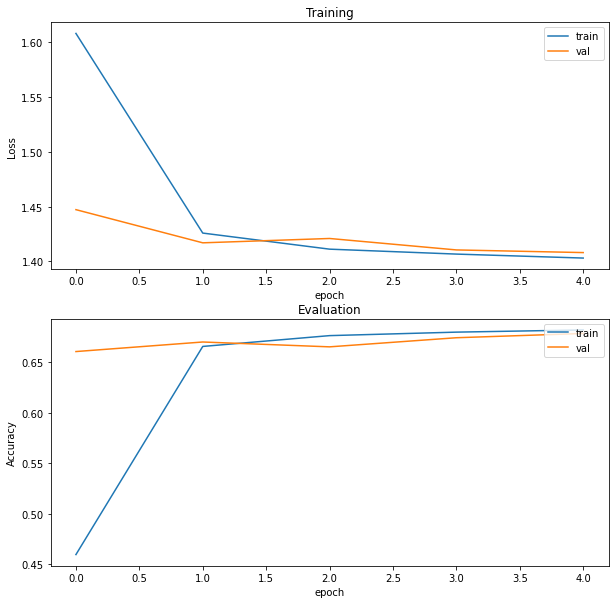

In [ ]:
plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.plot(train_losses)
plt.plot(eval_losses)
plt.title('Training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')


plt.subplot(212)
plt.plot(train_accuracy)
plt.plot(eval_accuracy)
plt.title('Evaluation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

Посмотрим на то, как модель предсказывает отдельные классы

In [ ]:
y_pred = []
y_true = []
for texts, y in val_iterator:   
    y_pred.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    y_true.extend(y.cpu().detach().numpy())
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       314
           1       0.00      0.00      0.00       156
           2       0.39      1.00      0.56      1810
           3       0.00      0.00      0.00       157
           4       0.00      0.00      0.00       892
           5       0.00      0.00      0.00      1368

    accuracy                           0.39      4697
   macro avg       0.06      0.17      0.09      4697
weighted avg       0.15      0.39      0.21      4697



Результаты ожидаемые: модель лучше предсказывать классы, по которым данных гораздо больше, чем остальных, а малочисленные совсем не предсказывает :(

### Experiments
For SST, we conduct hyperparameter (number of filters, filter length in CNN; memory dimension in LSTM; dropout rate and which layer to apply, etc.) tuning on the validation data in the standard split.

Так как параметров много, попробуем поставить эксперимент на некоторых из них: применим различные конфигурации фильтров, различные значения дропаута. Количество эпох оставим 5, иначе обучение будет очень долгим.

In [ ]:
experimental_filters = [[2], [3], [4], [2, 3], [3, 4], [2, 4], [2, 3, 4]]
results = []
for filter in experimental_filters:
    for dropout in [0, 0.2, 0.5]:
        model = C_LSTM(len(word2id), max_len=600, filter_sizes=filter,
                   filters_num=150, memory_dim=150, dropout_rate=dropout, 
                   dropout_input=False, dropout_lstm=True)
        model = model.to(DEVICE)
        optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
        criterion = nn.CrossEntropyLoss()
        criterion = criterion.to(DEVICE)
        print('Filter:', filter, 'dropout rate:', dropout)

        epochs = 5
        train_losses = []
        train_accuracy = []
        eval_losses = []
        eval_accuracy = []

        for epoch in range(epochs):
            print(f'\nstarting Epoch {epoch+1}')
            print('Training...')
            epoch_loss, epoch_metrics = train(model, optimizer, criterion, epoch)
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_metrics)
            print('\nEvaluating...')
            epoch_loss_eval, epoch_metrics_eval = evaluate(model, criterion)
            eval_losses.append(epoch_loss_eval)
            eval_accuracy.append(epoch_metrics_eval)
            
        results.append({'filter': filter,
                        'dropout': dropout,
                       'train_losses': train_losses,
                       'train_accuracy': train_accuracy,
                       'eval_losses': eval_losses,
                       'eval_accuracy': eval_accuracy})

Filter: [2] dropout rate: 0

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6509825443399364, Train metric: 0.4018377363681793
Train loss: 1.6473696951208443, Train metric: 0.4043101668357849
Train loss: 1.643984390401292, Train metric: 0.40860244631767273
Train loss: 1.6432897726009632, Train metric: 0.40758174657821655
Train loss: 1.6428626093371161, Train metric: 0.40882351994514465

Evaluating...
Val loss: 1.6254720517567225, Val metric: 0.42480215430259705
Val loss: 1.6414784022739954, Val metric: 0.4088577330112457
Val loss: 1.638740062713623, Val metric: 0.41503965854644775
Val loss: 1.638429548059191, Val metric: 0.4140310287475586
Val loss: 1.637400392123631, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6434731812312686, Train metric: 0.4086465537548065
Train loss: 1.6386897954447517, Train metric: 0.41590768098831177
Train loss: 1.6410898997865875, Train metric: 0.4121032655239105
Train loss: 1.6409808921402897, Train metric: 0.4120565354824066
Train loss: 1.6399729408066848, Train metric: 0.4132136404514313

Evaluating...
Val loss: 1.6333435773849487, Val metric: 0.4273150861263275
Val loss: 1.644912234374455, Val metric: 0.41313716769218445
Val loss: 1.6424532334009807, Val metric: 0.4174196720123291
Val loss: 1.641879562820707, Val metric: 0.41580820083618164
Val loss: 1.6404449122292655, Val metric: 0.42039090394973755

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6484849124119199, Train metric: 0.3984057605266571
Train loss: 1.6412617851947915, Train metric: 0.40788039565086365
Train loss: 1.638605032844105, Train metric: 0.4122210443019867
Train loss: 1.6352347813803574, Train metric: 0.4172928035259247
Train loss: 1.629547064879845, Train metric: 0.4280797839164734

Evaluating...
Val loss: 1.6337788956505912, Val metric: 0.42270731925964355
Val loss: 1.6449360506875175, Val metric: 0.416366845369339
Val loss: 1.6419532639639718, Val metric: 0.4175547957420349
Val loss: 1.6422680190631322, Val metric: 0.4155489504337311
Val loss: 1.6397297757012503, Val metric: 0.4194497764110565

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4997545562941452, Train metric: 0.6203094720840454
Train loss: 1.4658325869461586, Train metric: 0.643240749835968
Train loss: 1.4596565002682564, Train metric: 0.641867995262146
Train loss: 1.4487801759407437, Train metric: 0.6500178575515747
Train loss: 1.44275064797237, Train metric: 0.6529207229614258

Evaluating...
Val loss: 1.4213309969220842, Val metric: 0.6553348302841187
Val loss: 1.439352580479213, Val metric: 0.6423454880714417
Val loss: 1.4386680750619798, Val metric: 0.644189178943634
Val loss: 1.434606624501092, Val metric: 0.6456319689750671
Val loss: 1.433523508480617, Val metric: 0.6492384076118469

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4173336152372689, Train metric: 0.6631816625595093
Train loss: 1.4189956804801678, Train metric: 0.6637203693389893
Train loss: 1.4232260235424699, Train metric: 0.6584058403968811
Train loss: 1.4194311129635777, Train metric: 0.6640053391456604
Train loss: 1.4162176000660864, Train metric: 0.6685519218444824

Evaluating...
Val loss: 1.4313133784702845, Val metric: 0.6422648429870605
Val loss: 1.449543935911996, Val metric: 0.6284872889518738
Val loss: 1.4466909851346696, Val metric: 0.6329936981201172
Val loss: 1.4427248196942466, Val metric: 0.6351354718208313
Val loss: 1.4408467497144426, Val metric: 0.6393840312957764
Filter: [2] dropout rate: 0.2

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6528453045877918, Train metric: 0.4088754653930664
Train loss: 1.6454048814444706, Train metric: 0.4111000895500183
Train loss: 1.6444968437326366, Train metric: 0.4105339050292969
Train loss: 1.6427693839730888, Train metric: 0.4119151532649994
Train loss: 1.6430998695307764, Train metric: 0.41070789098739624

Evaluating...
Val loss: 1.62514705317361, Val metric: 0.42480215430259705
Val loss: 1.6403087377548218, Val metric: 0.4088577330112457
Val loss: 1.6382800454185122, Val metric: 0.41503965854644775
Val loss: 1.6378098385674613, Val metric: 0.4140310287475586
Val loss: 1.637022066116333, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6426095222604686, Train metric: 0.41722533106803894
Train loss: 1.6423571849691456, Train metric: 0.4113938808441162
Train loss: 1.638619391397498, Train metric: 0.41644230484962463
Train loss: 1.6380024295428703, Train metric: 0.41465631127357483
Train loss: 1.6376565275521113, Train metric: 0.41482049226760864

Evaluating...
Val loss: 1.6185181992394584, Val metric: 0.43809443712234497
Val loss: 1.6320117286273412, Val metric: 0.424686998128891
Val loss: 1.6319262016387213, Val metric: 0.4255152642726898
Val loss: 1.6313219453607286, Val metric: 0.42481881380081177
Val loss: 1.6308133465903145, Val metric: 0.42686185240745544

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6276422369069066, Train metric: 0.42374151945114136
Train loss: 1.6210325236978202, Train metric: 0.43720492720603943
Train loss: 1.5966787653407832, Train metric: 0.48188188672065735
Train loss: 1.5624151250411724, Train metric: 0.5216909050941467
Train loss: 1.5332925928050074, Train metric: 0.5519940853118896

Evaluating...
Val loss: 1.3946881123951502, Val metric: 0.6896550059318542
Val loss: 1.4160378915922982, Val metric: 0.6750748753547668
Val loss: 1.418620915639968, Val metric: 0.6707351803779602
Val loss: 1.4162464567593165, Val metric: 0.6702989935874939
Val loss: 1.415854331425258, Val metric: 0.6726358532905579

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4188608424416904, Train metric: 0.6633714437484741
Train loss: 1.4188201180819808, Train metric: 0.6662794351577759
Train loss: 1.4178526593350815, Train metric: 0.6663296222686768
Train loss: 1.4199950869741111, Train metric: 0.6627737879753113
Train loss: 1.4185458487477796, Train metric: 0.6650146842002869

Evaluating...
Val loss: 1.3940823248454504, Val metric: 0.6882578730583191
Val loss: 1.4148463095937456, Val metric: 0.6725743412971497
Val loss: 1.4167600245702834, Val metric: 0.6694908738136292
Val loss: 1.414239572627204, Val metric: 0.6693919897079468
Val loss: 1.4138100964682443, Val metric: 0.6716398596763611

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.3956243868531852, Train metric: 0.6920288801193237
Train loss: 1.4067433168148171, Train metric: 0.6767587065696716
Train loss: 1.4134142083683232, Train metric: 0.671937108039856
Train loss: 1.4136428822731149, Train metric: 0.6722531914710999
Train loss: 1.4119717269108214, Train metric: 0.6739510297775269

Evaluating...
Val loss: 1.4130758898598808, Val metric: 0.6601495742797852
Val loss: 1.4309741428920202, Val metric: 0.6483021378517151
Val loss: 1.4312262648627871, Val metric: 0.6485995054244995
Val loss: 1.4275730294840676, Val metric: 0.6507190465927124
Val loss: 1.4257033961159842, Val metric: 0.6552585959434509
Filter: [2] dropout rate: 0.5

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.658850390335609, Train metric: 0.39432981610298157
Train loss: 1.6495355408767174, Train metric: 0.3989856243133545
Train loss: 1.643099288830812, Train metric: 0.4080498218536377
Train loss: 1.644032408451212, Train metric: 0.4068094491958618
Train loss: 1.6434574595813094, Train metric: 0.407597154378891

Evaluating...
Val loss: 1.6252739429473877, Val metric: 0.42480215430259705
Val loss: 1.6411329422678267, Val metric: 0.4088577330112457
Val loss: 1.6385289827982585, Val metric: 0.41503965854644775
Val loss: 1.6381579382078988, Val metric: 0.4140310287475586
Val loss: 1.6372121810913085, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6342529099563072, Train metric: 0.4141327142715454
Train loss: 1.6384442510276005, Train metric: 0.4112415611743927
Train loss: 1.6381699093456925, Train metric: 0.41462305188179016
Train loss: 1.6401342595445698, Train metric: 0.4115913510322571
Train loss: 1.638505666831444, Train metric: 0.4143179953098297

Evaluating...
Val loss: 1.6220377853938512, Val metric: 0.42611852288246155
Val loss: 1.6366118788719177, Val metric: 0.4143724739551544
Val loss: 1.6352264710835047, Val metric: 0.4191046357154846
Val loss: 1.6344407669135503, Val metric: 0.41797807812690735
Val loss: 1.6336560453687394, Val metric: 0.42142176628112793

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6318530378670528, Train metric: 0.4174247682094574
Train loss: 1.6303698194438014, Train metric: 0.42131349444389343
Train loss: 1.6335057664191586, Train metric: 0.4205435514450073
Train loss: 1.6247701870984044, Train metric: 0.4404846429824829
Train loss: 1.6072375527743636, Train metric: 0.46950840950012207

Evaluating...
Val loss: 1.4745512860161918, Val metric: 0.6637015342712402
Val loss: 1.4885469675064087, Val metric: 0.6530324816703796
Val loss: 1.488263107481457, Val metric: 0.6524336934089661
Val loss: 1.4859777646405357, Val metric: 0.6527466773986816
Val loss: 1.48500725541796, Val metric: 0.6545001268386841

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4575834767571811, Train metric: 0.6435121893882751
Train loss: 1.4624997747355495, Train metric: 0.633927583694458
Train loss: 1.4508519583734973, Train metric: 0.6429685950279236
Train loss: 1.4456841997031509, Train metric: 0.6471332311630249
Train loss: 1.4386479533951857, Train metric: 0.6526927947998047

Evaluating...
Val loss: 1.3966587781906128, Val metric: 0.6908926963806152
Val loss: 1.4159167749541146, Val metric: 0.6781025528907776
Val loss: 1.4169847397577195, Val metric: 0.6735567450523376
Val loss: 1.4142925441265106, Val metric: 0.673692524433136
Val loss: 1.4144117730004446, Val metric: 0.6743758916854858

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4208291810134361, Train metric: 0.6635948419570923
Train loss: 1.415118279128239, Train metric: 0.6699641942977905
Train loss: 1.413889131326785, Train metric: 0.6702719330787659
Train loss: 1.4178715646266937, Train metric: 0.6650659441947937
Train loss: 1.418285743943576, Train metric: 0.6655985713005066

Evaluating...
Val loss: 1.3915965046201433, Val metric: 0.6920881271362305
Val loss: 1.4135459576334273, Val metric: 0.6738160252571106
Val loss: 1.4129255215326946, Val metric: 0.6740061044692993
Val loss: 1.4103833990437644, Val metric: 0.6758020520210266
Val loss: 1.4107220649719239, Val metric: 0.6768859028816223
Filter: [3] dropout rate: 0

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.651249832120435, Train metric: 0.40561166405677795
Train loss: 1.6474110648549836, Train metric: 0.40927034616470337
Train loss: 1.6460625371713749, Train metric: 0.4086533784866333
Train loss: 1.6425845992976222, Train metric: 0.41150549054145813
Train loss: 1.642634547989944, Train metric: 0.4105747640132904

Evaluating...
Val loss: 1.623363665172032, Val metric: 0.42480215430259705
Val loss: 1.6395829490252904, Val metric: 0.4088577330112457
Val loss: 1.637145922297523, Val metric: 0.41503965854644775
Val loss: 1.6367143094539642, Val metric: 0.4140310287475586
Val loss: 1.6358793905803135, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6351335459742053, Train metric: 0.40828436613082886
Train loss: 1.6344068769750923, Train metric: 0.41519254446029663
Train loss: 1.6314694059306178, Train metric: 0.4189941883087158
Train loss: 1.6245554377292764, Train metric: 0.43237361311912537
Train loss: 1.6011610376423804, Train metric: 0.46761131286621094

Evaluating...
Val loss: 1.416475738797869, Val metric: 0.6788539290428162
Val loss: 1.4353566680635725, Val metric: 0.6647706031799316
Val loss: 1.4358904021126884, Val metric: 0.6646641492843628
Val loss: 1.4320874767644065, Val metric: 0.6666799783706665
Val loss: 1.4314625433513097, Val metric: 0.6682807207107544

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4335522076179241, Train metric: 0.6545810103416443
Train loss: 1.4270434955070759, Train metric: 0.6623972654342651
Train loss: 1.4238030074656696, Train metric: 0.6646140217781067
Train loss: 1.423599347986024, Train metric: 0.6638813614845276
Train loss: 1.421625170214423, Train metric: 0.665812075138092

Evaluating...
Val loss: 1.3946694816861833, Val metric: 0.6860877871513367
Val loss: 1.4152317898614066, Val metric: 0.6684507131576538
Val loss: 1.4168404340744019, Val metric: 0.6675179600715637
Val loss: 1.413480384009225, Val metric: 0.6685701608657837
Val loss: 1.4128202336175102, Val metric: 0.6710258722305298

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.401690022698764, Train metric: 0.6885313987731934
Train loss: 1.4057313882071396, Train metric: 0.679373025894165
Train loss: 1.4067511243381718, Train metric: 0.677415668964386
Train loss: 1.4091932979123345, Train metric: 0.6746487617492676
Train loss: 1.4117902722851983, Train metric: 0.6733348965644836

Evaluating...
Val loss: 1.3940354074750627, Val metric: 0.693000316619873
Val loss: 1.4136218088013786, Val metric: 0.6749913096427917
Val loss: 1.4146006447928292, Val metric: 0.6714847683906555
Val loss: 1.4109418860503606, Val metric: 0.6735780835151672
Val loss: 1.4106248719351633, Val metric: 0.6752805113792419

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4189765001165455, Train metric: 0.6650024056434631
Train loss: 1.4267121676740975, Train metric: 0.6588708162307739
Train loss: 1.419762694972685, Train metric: 0.6659194827079773
Train loss: 1.4186408488914883, Train metric: 0.6661568880081177
Train loss: 1.4143440295910013, Train metric: 0.6711611747741699

Evaluating...
Val loss: 1.3862142733165197, Val metric: 0.6965875625610352
Val loss: 1.408193324293409, Val metric: 0.6779059767723083
Val loss: 1.4103222744805473, Val metric: 0.6738325357437134
Val loss: 1.4067571418625968, Val metric: 0.6760045886039734
Val loss: 1.4073531866073608, Val metric: 0.67693692445755
Filter: [3] dropout rate: 0.2

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6584291088170018, Train metric: 0.3818611800670624
Train loss: 1.651283270326154, Train metric: 0.396963894367218
Train loss: 1.646145784991911, Train metric: 0.4056185483932495
Train loss: 1.6450931316819684, Train metric: 0.40393775701522827
Train loss: 1.6421856263588215, Train metric: 0.4086024761199951

Evaluating...
Val loss: 1.6222897257123674, Val metric: 0.4272492229938507
Val loss: 1.6366562843322754, Val metric: 0.41065138578414917
Val loss: 1.6346306687309629, Val metric: 0.4177934527397156
Val loss: 1.6341266163757868, Val metric: 0.41669967770576477
Val loss: 1.633371935571943, Val metric: 0.42016997933387756

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6315421400399044, Train metric: 0.41623273491859436
Train loss: 1.6310361089377567, Train metric: 0.4196593165397644
Train loss: 1.626599947611491, Train metric: 0.4306826591491699
Train loss: 1.6192488690902447, Train metric: 0.4424062967300415
Train loss: 1.6112557328980543, Train metric: 0.454238623380661

Evaluating...
Val loss: 1.6697383608136858, Val metric: 0.401859849691391
Val loss: 1.675566622189113, Val metric: 0.39746907353401184
Val loss: 1.6795049394880022, Val metric: 0.39437630772590637
Val loss: 1.6784891741616386, Val metric: 0.3935205638408661
Val loss: 1.680802685873849, Val metric: 0.3913377821445465

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.5365610698173786, Train metric: 0.5434076189994812
Train loss: 1.5403904976515934, Train metric: 0.5379490256309509
Train loss: 1.5313336904021515, Train metric: 0.5479045510292053
Train loss: 1.5278199530881027, Train metric: 0.5522681474685669
Train loss: 1.524495664136163, Train metric: 0.5564203858375549

Evaluating...
Val loss: 1.5109714780535017, Val metric: 0.5638590455055237
Val loss: 1.5288122040884835, Val metric: 0.5491988062858582
Val loss: 1.5260304836999803, Val metric: 0.5532929301261902
Val loss: 1.5236924631255013, Val metric: 0.5541056394577026
Val loss: 1.5245713438306536, Val metric: 0.5544062852859497

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.517120283225487, Train metric: 0.562597930431366
Train loss: 1.5422605646067653, Train metric: 0.5352309942245483
Train loss: 1.5348451192351593, Train metric: 0.5431413650512695
Train loss: 1.53777872899483, Train metric: 0.5382412075996399
Train loss: 1.5343642506106145, Train metric: 0.5429137945175171

Evaluating...
Val loss: 1.491994857788086, Val metric: 0.584086000919342
Val loss: 1.5058574080467224, Val metric: 0.5738024711608887
Val loss: 1.5061448982783727, Val metric: 0.5743883848190308
Val loss: 1.5062010841710227, Val metric: 0.5734733939170837
Val loss: 1.5069301434925624, Val metric: 0.5736494064331055

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.708066804655667, Train metric: 0.3421291708946228
Train loss: 1.695334625655207, Train metric: 0.35896986722946167
Train loss: 1.6488222747013486, Train metric: 0.42174243927001953
Train loss: 1.6171413660049438, Train metric: 0.456482470035553
Train loss: 1.5959230439416294, Train metric: 0.47782033681869507

Evaluating...
Val loss: 1.5164011887141637, Val metric: 0.5642298460006714
Val loss: 1.5289642385074071, Val metric: 0.5556668043136597
Val loss: 1.5275079579580397, Val metric: 0.5563753247261047
Val loss: 1.525532909802028, Val metric: 0.5578322410583496
Val loss: 1.5255605288914271, Val metric: 0.5587760806083679
Filter: [3] dropout rate: 0.5

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.65430420842664, Train metric: 0.4010453522205353
Train loss: 1.6480165370579423, Train metric: 0.40722718834877014
Train loss: 1.6456476491073082, Train metric: 0.4098142981529236
Train loss: 1.6429523332365628, Train metric: 0.41364842653274536
Train loss: 1.6434767057155741, Train metric: 0.41135749220848083

Evaluating...
Val loss: 1.6255350794110979, Val metric: 0.42480215430259705
Val loss: 1.6409211584499903, Val metric: 0.4088577330112457
Val loss: 1.6390415259769984, Val metric: 0.41503965854644775
Val loss: 1.6384509759289878, Val metric: 0.4140310287475586
Val loss: 1.6379034655434745, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6384592179594368, Train metric: 0.41926848888397217
Train loss: 1.6331874276029652, Train metric: 0.42775967717170715
Train loss: 1.6371252509369247, Train metric: 0.42066752910614014
Train loss: 1.6349944040693085, Train metric: 0.42124420404434204
Train loss: 1.6300649585395024, Train metric: 0.43206217885017395

Evaluating...
Val loss: 1.5907728501728602, Val metric: 0.4957124590873718
Val loss: 1.6067859785897392, Val metric: 0.4775356650352478
Val loss: 1.6047470966974895, Val metric: 0.48287233710289
Val loss: 1.60323509148189, Val metric: 0.4819926619529724
Val loss: 1.6028698750904629, Val metric: 0.48342180252075195

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.5519328528437122, Train metric: 0.5706323981285095
Train loss: 1.505216160724903, Train metric: 0.6084178686141968
Train loss: 1.4815414842517896, Train metric: 0.625386118888855
Train loss: 1.466718167066574, Train metric: 0.6354082822799683
Train loss: 1.461264917768281, Train metric: 0.6380760073661804

Evaluating...
Val loss: 1.4198592730930872, Val metric: 0.6574733853340149
Val loss: 1.4375897135053362, Val metric: 0.6445360779762268
Val loss: 1.4347339868545532, Val metric: 0.6492332220077515
Val loss: 1.4311909973621368, Val metric: 0.6502861380577087
Val loss: 1.4287763493401664, Val metric: 0.6554036736488342

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4296654873880847, Train metric: 0.6481143832206726
Train loss: 1.4331378566807713, Train metric: 0.645112156867981
Train loss: 1.4361988251236664, Train metric: 0.6431823372840881
Train loss: 1.4311520169521201, Train metric: 0.6499742269515991
Train loss: 1.4283845564414714, Train metric: 0.6536152362823486

Evaluating...
Val loss: 1.3959507090704781, Val metric: 0.6884423494338989
Val loss: 1.4168008395603724, Val metric: 0.6726175546646118
Val loss: 1.417192016329084, Val metric: 0.67109614610672
Val loss: 1.4140707084110804, Val metric: 0.6712414026260376
Val loss: 1.4140023572104319, Val metric: 0.6731886863708496

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4166249365642154, Train metric: 0.6660107374191284
Train loss: 1.4216385894808277, Train metric: 0.6621829867362976
Train loss: 1.416071525935469, Train metric: 0.6684876084327698
Train loss: 1.4146812311534225, Train metric: 0.6701339483261108
Train loss: 1.4134725677556006, Train metric: 0.6715332269668579

Evaluating...
Val loss: 1.4051741191319056, Val metric: 0.6752546429634094
Val loss: 1.4291640264647347, Val metric: 0.656270444393158
Val loss: 1.4273277067002796, Val metric: 0.6591368317604065
Val loss: 1.4242591432162695, Val metric: 0.6608105301856995
Val loss: 1.4246587003980364, Val metric: 0.6614816784858704
Filter: [4] dropout rate: 0

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.657824446415079, Train metric: 0.38479411602020264
Train loss: 1.648967459284026, Train metric: 0.39795997738838196
Train loss: 1.6472648258866935, Train metric: 0.402123361825943
Train loss: 1.6446942245138103, Train metric: 0.4044822156429291
Train loss: 1.6421727361350225, Train metric: 0.4094041883945465

Evaluating...
Val loss: 1.6186974048614502, Val metric: 0.4250257611274719
Val loss: 1.6326464329447066, Val metric: 0.4150577187538147
Val loss: 1.6314924444471086, Val metric: 0.41950711607933044
Val loss: 1.6308069016252245, Val metric: 0.41971513628959656
Val loss: 1.6298647369657244, Val metric: 0.4237160384654999

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6291521088830356, Train metric: 0.42900267243385315
Train loss: 1.6301006900853123, Train metric: 0.42731180787086487
Train loss: 1.6337581270042507, Train metric: 0.4216766059398651
Train loss: 1.6314657741579517, Train metric: 0.42178091406822205
Train loss: 1.618406340171551, Train metric: 0.44636839628219604

Evaluating...
Val loss: 1.5292633771896362, Val metric: 0.577306866645813
Val loss: 1.5424743294715881, Val metric: 0.5614663362503052
Val loss: 1.5419243006479173, Val metric: 0.5584330558776855
Val loss: 1.5391680938856942, Val metric: 0.5605710744857788
Val loss: 1.5394239970615933, Val metric: 0.5607050061225891

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4483428782430188, Train metric: 0.6526815295219421
Train loss: 1.4346636759823765, Train metric: 0.6646222472190857
Train loss: 1.428894214246465, Train metric: 0.6679258942604065
Train loss: 1.4267680367519116, Train metric: 0.6668491959571838
Train loss: 1.4239030032322324, Train metric: 0.6685701608657837

Evaluating...
Val loss: 1.4017675604139055, Val metric: 0.6777061820030212
Val loss: 1.4236228976930891, Val metric: 0.6581088304519653
Val loss: 1.4234837123325892, Val metric: 0.6598272919654846
Val loss: 1.4195881060191564, Val metric: 0.6630728840827942
Val loss: 1.4189517327717371, Val metric: 0.6656367182731628

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.423821079319921, Train metric: 0.6620546579360962
Train loss: 1.4172962061290084, Train metric: 0.668545126914978
Train loss: 1.4132048234172252, Train metric: 0.6734386086463928
Train loss: 1.4170646400287235, Train metric: 0.6667022705078125
Train loss: 1.4166331842027862, Train metric: 0.6678983569145203

Evaluating...
Val loss: 1.404442616871425, Val metric: 0.6778804659843445
Val loss: 1.423206124986921, Val metric: 0.6613994240760803
Val loss: 1.4244034233547391, Val metric: 0.6592370271682739
Val loss: 1.4204729880605425, Val metric: 0.660211980342865
Val loss: 1.4197188888277326, Val metric: 0.662877082824707

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4276701828529095, Train metric: 0.6580331325531006
Train loss: 1.4327348676221123, Train metric: 0.6532503962516785
Train loss: 1.424535601988606, Train metric: 0.6611148715019226
Train loss: 1.4238473495532726, Train metric: 0.6618936657905579
Train loss: 1.4187590525068086, Train metric: 0.6660718321800232

Evaluating...
Val loss: 1.3927751438958305, Val metric: 0.6931110620498657
Val loss: 1.4116289700780595, Val metric: 0.6773291826248169
Val loss: 1.4118219386963617, Val metric: 0.6738826036453247
Val loss: 1.4086300602981023, Val metric: 0.6751540303230286
Val loss: 1.4090871265956333, Val metric: 0.6765180826187134
Filter: [4] dropout rate: 0.2

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6570471155232396, Train metric: 0.40523743629455566
Train loss: 1.6486656336948788, Train metric: 0.4091940224170685
Train loss: 1.6447045830474503, Train metric: 0.4106244444847107
Train loss: 1.6439661948845303, Train metric: 0.4111291766166687
Train loss: 1.6429357339595927, Train metric: 0.41153526306152344

Evaluating...
Val loss: 1.6223724739892142, Val metric: 0.4271569550037384
Val loss: 1.6375936780657088, Val metric: 0.41061586141586304
Val loss: 1.6354503801890783, Val metric: 0.4169890880584717
Val loss: 1.6351330918925149, Val metric: 0.4154931604862213
Val loss: 1.6342978818075997, Val metric: 0.4189929664134979

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6314344570554535, Train metric: 0.43169689178466797
Train loss: 1.6338781180052921, Train metric: 0.42315900325775146
Train loss: 1.6265885857329971, Train metric: 0.4299562871456146
Train loss: 1.603282289258365, Train metric: 0.47710078954696655
Train loss: 1.5727259915450524, Train metric: 0.5125831365585327

Evaluating...
Val loss: 1.4036612510681152, Val metric: 0.6919367909431458
Val loss: 1.4259459035737174, Val metric: 0.6756559014320374
Val loss: 1.4263586770920527, Val metric: 0.6731806993484497
Val loss: 1.4239357667309898, Val metric: 0.6731075048446655
Val loss: 1.4244881664003646, Val metric: 0.6737271547317505

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4118546658548816, Train metric: 0.6786226034164429
Train loss: 1.4099468218869176, Train metric: 0.6820887923240662
Train loss: 1.4200664457233472, Train metric: 0.6681190729141235
Train loss: 1.4172714517034333, Train metric: 0.6711256504058838
Train loss: 1.4172257374072896, Train metric: 0.6709902882575989

Evaluating...
Val loss: 1.3937745945794242, Val metric: 0.6930148005485535
Val loss: 1.4135488527161735, Val metric: 0.6755337715148926
Val loss: 1.4147233849480039, Val metric: 0.672677755355835
Val loss: 1.4112113543919154, Val metric: 0.6741775274276733
Val loss: 1.4113534586770193, Val metric: 0.6759983897209167

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4116004458789169, Train metric: 0.6745041608810425
Train loss: 1.411419821196589, Train metric: 0.6750076413154602
Train loss: 1.413391532569096, Train metric: 0.6748625040054321
Train loss: 1.4150268939034691, Train metric: 0.672265350818634
Train loss: 1.4142763622875871, Train metric: 0.6728839874267578

Evaluating...
Val loss: 1.398044262613569, Val metric: 0.6802095770835876
Val loss: 1.4182837350027901, Val metric: 0.6666186451911926
Val loss: 1.4190813302993774, Val metric: 0.6655805706977844
Val loss: 1.4156043529510498, Val metric: 0.667351245880127
Val loss: 1.4149038621357508, Val metric: 0.6705160140991211

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4095201245669662, Train metric: 0.6724684238433838
Train loss: 1.4072404935442169, Train metric: 0.680153489112854
Train loss: 1.4044024629154424, Train metric: 0.6825388669967651
Train loss: 1.4104778119202317, Train metric: 0.6764724254608154
Train loss: 1.4107465661805252, Train metric: 0.6748698353767395

Evaluating...
Val loss: 1.3954169239316667, Val metric: 0.6894884705543518
Val loss: 1.4126005598476954, Val metric: 0.6743215322494507
Val loss: 1.411828949337914, Val metric: 0.6746659278869629
Val loss: 1.408218217747552, Val metric: 0.6766002774238586
Val loss: 1.4078458513532366, Val metric: 0.6784148216247559
Filter: [4] dropout rate: 0.5

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6474977115104938, Train metric: 0.41465723514556885
Train loss: 1.6465263387252544, Train metric: 0.41277816891670227
Train loss: 1.6420670679245872, Train metric: 0.4162771701812744
Train loss: 1.6421330828091194, Train metric: 0.4152613580226898
Train loss: 1.6432796050762308, Train metric: 0.41181913018226624

Evaluating...
Val loss: 1.6253245728356498, Val metric: 0.42480215430259705
Val loss: 1.64067884853908, Val metric: 0.4088577330112457
Val loss: 1.6382809423265003, Val metric: 0.41503965854644775
Val loss: 1.6379181231771196, Val metric: 0.4140310287475586
Val loss: 1.6369770935603551, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6394466655007724, Train metric: 0.4103586673736572
Train loss: 1.6394427418708801, Train metric: 0.41270554065704346
Train loss: 1.640470900754819, Train metric: 0.4116706848144531
Train loss: 1.6378535803022056, Train metric: 0.41426974534988403
Train loss: 1.6344200915303724, Train metric: 0.4191417694091797

Evaluating...
Val loss: 1.5715888568333216, Val metric: 0.49471515417099
Val loss: 1.5868259498051234, Val metric: 0.4777635633945465
Val loss: 1.5847452311288743, Val metric: 0.483438640832901
Val loss: 1.5836030159677779, Val metric: 0.4850797653198242
Val loss: 1.5834886857441492, Val metric: 0.4875607192516327

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.5423447880251655, Train metric: 0.5972731113433838
Train loss: 1.5018266048924676, Train metric: 0.6259652972221375
Train loss: 1.47534088019667, Train metric: 0.6412419080734253
Train loss: 1.4631104469299316, Train metric: 0.6468098759651184
Train loss: 1.4505002145109505, Train metric: 0.6551326513290405

Evaluating...
Val loss: 1.394176755632673, Val metric: 0.690934956073761
Val loss: 1.413983336516789, Val metric: 0.677472710609436
Val loss: 1.4145195427395048, Val metric: 0.6748032569885254
Val loss: 1.4118536923612868, Val metric: 0.6755216717720032
Val loss: 1.4120203699384417, Val metric: 0.6771082282066345

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.424491993312178, Train metric: 0.664750337600708
Train loss: 1.4197050846856216, Train metric: 0.667026162147522
Train loss: 1.4162169681198296, Train metric: 0.6702612638473511
Train loss: 1.414357251134412, Train metric: 0.6705995798110962
Train loss: 1.411133519534407, Train metric: 0.6741015315055847

Evaluating...
Val loss: 1.3960081509181432, Val metric: 0.6871823668479919
Val loss: 1.4163053291184562, Val metric: 0.6720033288002014
Val loss: 1.4150161743164062, Val metric: 0.6731314659118652
Val loss: 1.4122852001871382, Val metric: 0.6733845472335815
Val loss: 1.412313049180167, Val metric: 0.6748788952827454

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4133762737800335, Train metric: 0.6714547872543335
Train loss: 1.4172289330383827, Train metric: 0.6660141348838806
Train loss: 1.4179550135272674, Train metric: 0.664868950843811
Train loss: 1.4150491634319569, Train metric: 0.6693362593650818
Train loss: 1.4153965021001882, Train metric: 0.668232798576355

Evaluating...
Val loss: 1.3985773154667445, Val metric: 0.6695356369018555
Val loss: 1.416197725704738, Val metric: 0.657128632068634
Val loss: 1.4161568198885237, Val metric: 0.6584507822990417
Val loss: 1.4118678612368447, Val metric: 0.6630831956863403
Val loss: 1.4117637259619578, Val metric: 0.6637626886367798
Filter: [2, 3] dropout rate: 0

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.653009583210123, Train metric: 0.40415728092193604
Train loss: 1.6472341623799553, Train metric: 0.40933823585510254
Train loss: 1.6466178962554054, Train metric: 0.40649592876434326
Train loss: 1.643381818615157, Train metric: 0.4110313951969147
Train loss: 1.6424683365328558, Train metric: 0.4103199541568756

Evaluating...
Val loss: 1.623047845704215, Val metric: 0.42599552869796753
Val loss: 1.6375005074909754, Val metric: 0.4094544053077698
Val loss: 1.6359616234188987, Val metric: 0.41621479392051697
Val loss: 1.6355231957776206, Val metric: 0.4149147868156433
Val loss: 1.6351439680371966, Val metric: 0.4180520474910736

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6375925335390815, Train metric: 0.41493743658065796
Train loss: 1.6337462314243973, Train metric: 0.42094162106513977
Train loss: 1.6277730944512905, Train metric: 0.42504826188087463
Train loss: 1.6108819194908799, Train metric: 0.45932063460350037
Train loss: 1.582607525792615, Train metric: 0.4958648681640625

Evaluating...
Val loss: 1.4582315342766898, Val metric: 0.6199253797531128
Val loss: 1.4791979789733887, Val metric: 0.5997901558876038
Val loss: 1.4790952375956945, Val metric: 0.6004458665847778
Val loss: 1.4763623007706232, Val metric: 0.6019507050514221
Val loss: 1.474685423714774, Val metric: 0.6048458218574524

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4285526275634766, Train metric: 0.659172773361206
Train loss: 1.4282774863571956, Train metric: 0.6626580953598022
Train loss: 1.420537717040928, Train metric: 0.667885959148407
Train loss: 1.4201843543299313, Train metric: 0.6669970154762268
Train loss: 1.4205462348872218, Train metric: 0.6665152907371521

Evaluating...
Val loss: 1.3923815318516322, Val metric: 0.689585268497467
Val loss: 1.4113673908369881, Val metric: 0.6767927408218384
Val loss: 1.412390078817095, Val metric: 0.6742699146270752
Val loss: 1.4096531867980957, Val metric: 0.6756966710090637
Val loss: 1.4098068237304688, Val metric: 0.6769307851791382

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4127476626429065, Train metric: 0.6729931831359863
Train loss: 1.4080313382477596, Train metric: 0.6784554123878479
Train loss: 1.4076555665882153, Train metric: 0.678561270236969
Train loss: 1.4098216624095523, Train metric: 0.674719512462616
Train loss: 1.4174364163957793, Train metric: 0.6676393747329712

Evaluating...
Val loss: 1.386569789477757, Val metric: 0.6991714239120483
Val loss: 1.4087674021720886, Val metric: 0.6810683012008667
Val loss: 1.4101570390519642, Val metric: 0.6783550977706909
Val loss: 1.4077627786568232, Val metric: 0.6787408590316772
Val loss: 1.4079712356839862, Val metric: 0.6800877451896667

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4126826689161103, Train metric: 0.6727064847946167
Train loss: 1.4166615153181141, Train metric: 0.6659285426139832
Train loss: 1.4162855655297466, Train metric: 0.6668732762336731
Train loss: 1.4170342622132137, Train metric: 0.6668523550033569
Train loss: 1.4202753609624403, Train metric: 0.6626927852630615

Evaluating...
Val loss: 1.4152542182377406, Val metric: 0.6588387489318848
Val loss: 1.4344248686517989, Val metric: 0.6439358592033386
Val loss: 1.4308716683160692, Val metric: 0.650134801864624
Val loss: 1.4284045483384813, Val metric: 0.6494632959365845
Val loss: 1.427683789389474, Val metric: 0.6530492305755615
Filter: [2, 3] dropout rate: 0.2

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.656570397574326, Train metric: 0.38318532705307007
Train loss: 1.6519397291643867, Train metric: 0.38979318737983704
Train loss: 1.6431180252425972, Train metric: 0.40513554215431213
Train loss: 1.6437538687525124, Train metric: 0.4047645330429077
Train loss: 1.6428981731677879, Train metric: 0.40698662400245667

Evaluating...
Val loss: 1.6254781144005912, Val metric: 0.42480215430259705
Val loss: 1.6400716304779053, Val metric: 0.4088577330112457
Val loss: 1.6374784991854714, Val metric: 0.41503965854644775
Val loss: 1.6372341130461012, Val metric: 0.4140310287475586
Val loss: 1.6361105714525495, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6367599142008815, Train metric: 0.4188111126422882
Train loss: 1.6350707802279243, Train metric: 0.4193238317966461
Train loss: 1.632249467674343, Train metric: 0.4190921187400818
Train loss: 1.6197895900956516, Train metric: 0.44875597953796387
Train loss: 1.5958710415609951, Train metric: 0.48726174235343933

Evaluating...
Val loss: 1.4368019444601876, Val metric: 0.6765111684799194
Val loss: 1.4537432960101537, Val metric: 0.663178026676178
Val loss: 1.453306516011556, Val metric: 0.662800669670105
Val loss: 1.4495421350002289, Val metric: 0.6649550199508667
Val loss: 1.448621187891279, Val metric: 0.6664251089096069

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.440221198673906, Train metric: 0.6572686433792114
Train loss: 1.4289837931764537, Train metric: 0.664923906326294
Train loss: 1.4272820250741367, Train metric: 0.6625378727912903
Train loss: 1.4223689426635873, Train metric: 0.6666276454925537
Train loss: 1.4238181763681872, Train metric: 0.6639267206192017

Evaluating...
Val loss: 1.4006900957652502, Val metric: 0.6788512468338013
Val loss: 1.4188002262796675, Val metric: 0.6690183877944946
Val loss: 1.4197829961776733, Val metric: 0.6666756868362427
Val loss: 1.4158475015844618, Val metric: 0.6699533462524414
Val loss: 1.415620149884905, Val metric: 0.671864926815033

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.412809655584138, Train metric: 0.6658380627632141
Train loss: 1.418356492601592, Train metric: 0.6629295945167542
Train loss: 1.421171910461338, Train metric: 0.6592660546302795
Train loss: 1.4200645685195923, Train metric: 0.663906991481781
Train loss: 1.4164097695515074, Train metric: 0.6677131056785583

Evaluating...
Val loss: 1.4322388172149658, Val metric: 0.6527673006057739
Val loss: 1.4579149399484908, Val metric: 0.6304752230644226
Val loss: 1.4554808764230638, Val metric: 0.6338936686515808
Val loss: 1.4539085669176919, Val metric: 0.6332160234451294
Val loss: 1.4542365653174265, Val metric: 0.6340942978858948

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4230808101851364, Train metric: 0.6654497981071472
Train loss: 1.41581189015816, Train metric: 0.6715306639671326
Train loss: 1.4104522562575066, Train metric: 0.6743177771568298
Train loss: 1.4111583171219662, Train metric: 0.6728973388671875
Train loss: 1.4120936130655224, Train metric: 0.6730906367301941

Evaluating...
Val loss: 1.391614351953779, Val metric: 0.6894763112068176
Val loss: 1.4128932867731367, Val metric: 0.6731238961219788
Val loss: 1.4119061401912145, Val metric: 0.673119306564331
Val loss: 1.4099110109465463, Val metric: 0.6730519533157349
Val loss: 1.409940242767334, Val metric: 0.6746512651443481
Filter: [2, 3] dropout rate: 0.5

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6550560655265019, Train metric: 0.3922514319419861
Train loss: 1.6443427657258922, Train metric: 0.40564751625061035
Train loss: 1.6426288848635795, Train metric: 0.40807032585144043
Train loss: 1.6417201346364514, Train metric: 0.4114852547645569
Train loss: 1.6428824474071635, Train metric: 0.40843504667282104

Evaluating...
Val loss: 1.6336136545453752, Val metric: 0.42480215430259705
Val loss: 1.6508064780916487, Val metric: 0.4088577330112457
Val loss: 1.6466168562571208, Val metric: 0.41503965854644775
Val loss: 1.646957848753248, Val metric: 0.4140310287475586
Val loss: 1.645186758041382, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6399539256918019, Train metric: 0.4151071608066559
Train loss: 1.634987810562397, Train metric: 0.4233733117580414
Train loss: 1.6361767560586162, Train metric: 0.4210573434829712
Train loss: 1.6352565504353622, Train metric: 0.4215049743652344
Train loss: 1.6344420983873564, Train metric: 0.4205639958381653

Evaluating...
Val loss: 1.6083485228674752, Val metric: 0.43934693932533264
Val loss: 1.6218634247779846, Val metric: 0.4277011454105377
Val loss: 1.6205672082446871, Val metric: 0.43112483620643616
Val loss: 1.6206513770989008, Val metric: 0.42783746123313904
Val loss: 1.6205145631517683, Val metric: 0.4302404820919037

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6206776931368072, Train metric: 0.4270341098308563
Train loss: 1.5814980597331607, Train metric: 0.5147438645362854
Train loss: 1.5408590895006027, Train metric: 0.5616570711135864
Train loss: 1.5146007178158596, Train metric: 0.5859081745147705
Train loss: 1.4950864939854063, Train metric: 0.6039403676986694

Evaluating...
Val loss: 1.3914318936211723, Val metric: 0.6968003511428833
Val loss: 1.4162017277308874, Val metric: 0.6768122911453247
Val loss: 1.4163335107621693, Val metric: 0.6755668520927429
Val loss: 1.413297223193305, Val metric: 0.6763473153114319
Val loss: 1.4137142896652222, Val metric: 0.6773200035095215

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4101024783890823, Train metric: 0.6739707589149475
Train loss: 1.4071041386702965, Train metric: 0.678846538066864
Train loss: 1.4079746542305782, Train metric: 0.6776319146156311
Train loss: 1.4085803073028038, Train metric: 0.6777653694152832
Train loss: 1.4104332808790536, Train metric: 0.6769932508468628

Evaluating...
Val loss: 1.3896982840129308, Val metric: 0.6931713819503784
Val loss: 1.4118864451135908, Val metric: 0.6761890649795532
Val loss: 1.410967815489996, Val metric: 0.6771984100341797
Val loss: 1.4089734213692802, Val metric: 0.6764194369316101
Val loss: 1.4096736567361015, Val metric: 0.677334189414978

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4004924913932537, Train metric: 0.6836478114128113
Train loss: 1.4190452982639443, Train metric: 0.666008472442627
Train loss: 1.418787077925671, Train metric: 0.6664012670516968
Train loss: 1.4151603137624675, Train metric: 0.6699087619781494
Train loss: 1.4126847711102717, Train metric: 0.6731311082839966

Evaluating...
Val loss: 1.4057313885007585, Val metric: 0.6682709455490112
Val loss: 1.420997483389718, Val metric: 0.6614406704902649
Val loss: 1.4215047189167567, Val metric: 0.6605743169784546
Val loss: 1.4177670436246055, Val metric: 0.6603447198867798
Val loss: 1.416692750794547, Val metric: 0.6622063517570496
Filter: [3, 4] dropout rate: 0

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.65394245345017, Train metric: 0.3973792493343353
Train loss: 1.6450248257867222, Train metric: 0.4085540473461151
Train loss: 1.644069468838045, Train metric: 0.40923818945884705
Train loss: 1.6430620057829495, Train metric: 0.40947332978248596
Train loss: 1.6429531944209133, Train metric: 0.40915554761886597

Evaluating...
Val loss: 1.623709797859192, Val metric: 0.42480215430259705
Val loss: 1.6383288672992162, Val metric: 0.4088577330112457
Val loss: 1.6358117092223394, Val metric: 0.41503965854644775
Val loss: 1.6354864154543196, Val metric: 0.4140310287475586
Val loss: 1.6343431030000959, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6368569957798924, Train metric: 0.42036134004592896
Train loss: 1.6362224858382652, Train metric: 0.4175446927547455
Train loss: 1.6338430547166145, Train metric: 0.4188980460166931
Train loss: 1.6307615719992539, Train metric: 0.4241127669811249
Train loss: 1.6183971158389387, Train metric: 0.45336297154426575

Evaluating...
Val loss: 1.5264726536614555, Val metric: 0.6115320324897766
Val loss: 1.5401980366025652, Val metric: 0.598365843296051
Val loss: 1.5402377503258842, Val metric: 0.6011970639228821
Val loss: 1.5384258031845093, Val metric: 0.6021475195884705
Val loss: 1.5382893596376692, Val metric: 0.6014037132263184

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.488315931681929, Train metric: 0.644442081451416
Train loss: 1.4580190551692043, Train metric: 0.6545880436897278
Train loss: 1.4516081179695568, Train metric: 0.6523463726043701
Train loss: 1.4428773810123574, Train metric: 0.6570247411727905
Train loss: 1.4381548930858743, Train metric: 0.65981525182724

Evaluating...
Val loss: 1.4053207295281547, Val metric: 0.6767216920852661
Val loss: 1.4267340217317854, Val metric: 0.6571847200393677
Val loss: 1.4268956695284163, Val metric: 0.6568585634231567
Val loss: 1.422926425933838, Val metric: 0.6590560078620911
Val loss: 1.4218923841203963, Val metric: 0.6619482040405273

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4228935652765735, Train metric: 0.666649580001831
Train loss: 1.4153998083081738, Train metric: 0.6737764477729797
Train loss: 1.4155807070348454, Train metric: 0.6705425977706909
Train loss: 1.415365322910506, Train metric: 0.6706077456474304
Train loss: 1.411530585946708, Train metric: 0.6741114258766174

Evaluating...
Val loss: 1.3879614898136683, Val metric: 0.6942961812019348
Val loss: 1.4120329022407532, Val metric: 0.6755849123001099
Val loss: 1.4119539658228557, Val metric: 0.6747632026672363
Val loss: 1.4090797475406103, Val metric: 0.6757693290710449
Val loss: 1.4096116713115148, Val metric: 0.6775527000427246

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4040901249852673, Train metric: 0.6787137389183044
Train loss: 1.4058054706145977, Train metric: 0.6791166663169861
Train loss: 1.4100611415402642, Train metric: 0.6755104660987854
Train loss: 1.409528104395702, Train metric: 0.6753479242324829
Train loss: 1.4092914194896304, Train metric: 0.6757573485374451

Evaluating...
Val loss: 1.3905382326671056, Val metric: 0.6930866241455078
Val loss: 1.4134041496685572, Val metric: 0.6756013035774231
Val loss: 1.4128110295250302, Val metric: 0.6743448972702026
Val loss: 1.4096098329339708, Val metric: 0.6751527786254883
Val loss: 1.4103075776781355, Val metric: 0.6765873432159424
Filter: [3, 4] dropout rate: 0.2

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.65342888749879, Train metric: 0.4082791805267334
Train loss: 1.6478571316291546, Train metric: 0.41109001636505127
Train loss: 1.64645730489972, Train metric: 0.41133055090904236
Train loss: 1.643551918967017, Train metric: 0.41245144605636597
Train loss: 1.643041595919379, Train metric: 0.4113532304763794

Evaluating...
Val loss: 1.6234032767159599, Val metric: 0.4260231852531433
Val loss: 1.6379882437842233, Val metric: 0.40946823358535767
Val loss: 1.6365786847614108, Val metric: 0.4158369302749634
Val loss: 1.6359910411494119, Val metric: 0.4146290123462677
Val loss: 1.6358070032937186, Val metric: 0.41733086109161377

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.639217471254283, Train metric: 0.4112226963043213
Train loss: 1.6263253113319134, Train metric: 0.4282452464103699
Train loss: 1.598649877241288, Train metric: 0.47810447216033936
Train loss: 1.5588740315930596, Train metric: 0.5233544111251831
Train loss: 1.5355582607203517, Train metric: 0.5498589277267456

Evaluating...
Val loss: 1.4054255826132638, Val metric: 0.6835892796516418
Val loss: 1.4275138463292802, Val metric: 0.6635783314704895
Val loss: 1.4265193314779372, Val metric: 0.6651009917259216
Val loss: 1.4224719958645957, Val metric: 0.6670381426811218
Val loss: 1.4219375269753591, Val metric: 0.6697937250137329

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4254898655003514, Train metric: 0.6619961261749268
Train loss: 1.4189432427800934, Train metric: 0.6688622236251831
Train loss: 1.415037331909969, Train metric: 0.672650933265686
Train loss: 1.4130257326981117, Train metric: 0.6743040680885315
Train loss: 1.4151072074627054, Train metric: 0.6723891496658325

Evaluating...
Val loss: 1.3925475903919764, Val metric: 0.691999614238739
Val loss: 1.4118120414870126, Val metric: 0.6792260408401489
Val loss: 1.412187831742423, Val metric: 0.6751572489738464
Val loss: 1.4092777712004525, Val metric: 0.6757993698120117
Val loss: 1.4096292223249163, Val metric: 0.6775525212287903

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4045092031873505, Train metric: 0.6759607195854187
Train loss: 1.4091654481558964, Train metric: 0.673296332359314
Train loss: 1.4093001985001838, Train metric: 0.6742333769798279
Train loss: 1.4081731274210174, Train metric: 0.6763888001441956
Train loss: 1.410432298430081, Train metric: 0.6750149130821228

Evaluating...
Val loss: 1.3877941370010376, Val metric: 0.6942736506462097
Val loss: 1.4086105823516846, Val metric: 0.6780052781105042
Val loss: 1.410331754457383, Val metric: 0.6739087104797363
Val loss: 1.4068712081227983, Val metric: 0.6754466891288757
Val loss: 1.40670405455998, Val metric: 0.6781544089317322

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4149920858185867, Train metric: 0.6700164675712585
Train loss: 1.4185472829588528, Train metric: 0.6674851179122925
Train loss: 1.4150306534493107, Train metric: 0.6724033951759338
Train loss: 1.4118983498935043, Train metric: 0.6744771003723145
Train loss: 1.4095650064534155, Train metric: 0.675995409488678

Evaluating...
Val loss: 1.395019258771624, Val metric: 0.6872600317001343
Val loss: 1.41600136246, Val metric: 0.6701439023017883
Val loss: 1.4163233268828619, Val metric: 0.66905277967453
Val loss: 1.412664647613253, Val metric: 0.6705803871154785
Val loss: 1.4123857634408132, Val metric: 0.6728441119194031
Filter: [3, 4] dropout rate: 0.5

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6535118653856475, Train metric: 0.389910489320755
Train loss: 1.6492208427396313, Train metric: 0.3976181149482727
Train loss: 1.6443440845642967, Train metric: 0.40432053804397583
Train loss: 1.6412568390369415, Train metric: 0.41133442521095276
Train loss: 1.6401169842687147, Train metric: 0.41153502464294434

Evaluating...
Val loss: 1.6060981750488281, Val metric: 0.43099093437194824
Val loss: 1.617845092500959, Val metric: 0.4234529435634613
Val loss: 1.616178898584275, Val metric: 0.4266606271266937
Val loss: 1.6151333962168013, Val metric: 0.42596325278282166
Val loss: 1.6146301405770438, Val metric: 0.4292140305042267

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.5734878572924385, Train metric: 0.5202142596244812
Train loss: 1.5134678770755898, Train metric: 0.5899408459663391
Train loss: 1.4835240210609875, Train metric: 0.6158069968223572
Train loss: 1.4667629805104485, Train metric: 0.6298556327819824
Train loss: 1.4569063573048033, Train metric: 0.638404905796051

Evaluating...
Val loss: 1.3902658905301775, Val metric: 0.6953827142715454
Val loss: 1.4105126176561629, Val metric: 0.6779280304908752
Val loss: 1.412782317116147, Val metric: 0.6750875115394592
Val loss: 1.4098411543028695, Val metric: 0.6760449409484863
Val loss: 1.4090083462851388, Val metric: 0.6786847710609436

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.440270053929296, Train metric: 0.6509847044944763
Train loss: 1.4284733780499161, Train metric: 0.6584488153457642
Train loss: 1.4227255843151574, Train metric: 0.663766622543335
Train loss: 1.4234005675233643, Train metric: 0.6628101468086243
Train loss: 1.4209729835904878, Train metric: 0.6646980047225952

Evaluating...
Val loss: 1.3931385959897722, Val metric: 0.6884315609931946
Val loss: 1.4129763330732072, Val metric: 0.6732016801834106
Val loss: 1.413178875332787, Val metric: 0.6719248294830322
Val loss: 1.4104102679661341, Val metric: 0.6727473139762878
Val loss: 1.410375326020377, Val metric: 0.67436283826828

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4048403830363834, Train metric: 0.6796320676803589
Train loss: 1.4126355586380794, Train metric: 0.6733309626579285
Train loss: 1.4118206240664954, Train metric: 0.6732600331306458
Train loss: 1.4086674390168026, Train metric: 0.676476001739502
Train loss: 1.4085704811688127, Train metric: 0.6772961020469666

Evaluating...
Val loss: 1.3940450293677193, Val metric: 0.6882293820381165
Val loss: 1.412613034248352, Val metric: 0.6712828278541565
Val loss: 1.412146119844346, Val metric: 0.6714434623718262
Val loss: 1.4084497136729104, Val metric: 0.6744681000709534
Val loss: 1.4075842687061855, Val metric: 0.6776247024536133

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4185490649321983, Train metric: 0.6706659197807312
Train loss: 1.4225913738382274, Train metric: 0.6653338074684143
Train loss: 1.4176338938460953, Train metric: 0.6694720387458801
Train loss: 1.415091904072926, Train metric: 0.6708912253379822
Train loss: 1.414203876462476, Train metric: 0.6718140840530396

Evaluating...
Val loss: 1.3908265658787318, Val metric: 0.6873155832290649
Val loss: 1.4119178227015905, Val metric: 0.6726190447807312
Val loss: 1.4115028381347656, Val metric: 0.6727749705314636
Val loss: 1.4091129302978516, Val metric: 0.6734170317649841
Val loss: 1.4093656301498414, Val metric: 0.6753617525100708
Filter: [2, 4] dropout rate: 0

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.648991613552488, Train metric: 0.3954949676990509
Train loss: 1.645594426270189, Train metric: 0.4036182165145874
Train loss: 1.6429532807448815, Train metric: 0.40579527616500854
Train loss: 1.642552056189241, Train metric: 0.4077621400356293
Train loss: 1.6414910826189764, Train metric: 0.4088113009929657

Evaluating...
Val loss: 1.6237696068627494, Val metric: 0.42378416657447815
Val loss: 1.6342781441552299, Val metric: 0.4174003005027771
Val loss: 1.6336343742552257, Val metric: 0.4214102327823639
Val loss: 1.6319876738956995, Val metric: 0.42286211252212524
Val loss: 1.6312298059463501, Val metric: 0.4264969825744629

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6045668371792496, Train metric: 0.44958794116973877
Train loss: 1.5666630925803349, Train metric: 0.5366003513336182
Train loss: 1.53609805819632, Train metric: 0.5759791135787964
Train loss: 1.5115305801917767, Train metric: 0.5970039367675781
Train loss: 1.4946491266119069, Train metric: 0.6109387278556824

Evaluating...
Val loss: 1.40085688659123, Val metric: 0.682409405708313
Val loss: 1.4239552531923567, Val metric: 0.6629534363746643
Val loss: 1.4239681164423625, Val metric: 0.663885235786438
Val loss: 1.420838121856962, Val metric: 0.6673003435134888
Val loss: 1.4206195320401873, Val metric: 0.6682949066162109

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4190792708561337, Train metric: 0.6686474084854126
Train loss: 1.4272740997117142, Train metric: 0.660140872001648
Train loss: 1.4273185222998432, Train metric: 0.6627488732337952
Train loss: 1.4282084425975536, Train metric: 0.661587119102478
Train loss: 1.4226288655708577, Train metric: 0.6675865650177002

Evaluating...
Val loss: 1.3895795345306396, Val metric: 0.6978821754455566
Val loss: 1.4119096994400024, Val metric: 0.6804060935974121
Val loss: 1.412543813387553, Val metric: 0.6767409443855286
Val loss: 1.4098339974880219, Val metric: 0.6769844889640808
Val loss: 1.4101666722978865, Val metric: 0.6782328486442566

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.415051793229991, Train metric: 0.6696864366531372
Train loss: 1.4133658285798698, Train metric: 0.6730346083641052
Train loss: 1.4102259353659619, Train metric: 0.6753882765769958
Train loss: 1.418128137958461, Train metric: 0.666673481464386
Train loss: 1.4214856665709923, Train metric: 0.6617651581764221

Evaluating...
Val loss: 1.4063308238983154, Val metric: 0.6787360310554504
Val loss: 1.4242542471204485, Val metric: 0.6599744558334351
Val loss: 1.423944115638733, Val metric: 0.6614713072776794
Val loss: 1.4198487826756068, Val metric: 0.6640130281448364
Val loss: 1.4194681780678886, Val metric: 0.6671268343925476

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4033060032745888, Train metric: 0.6807979345321655
Train loss: 1.4081456805097645, Train metric: 0.6777269244194031
Train loss: 1.4107342067806201, Train metric: 0.6756624579429626
Train loss: 1.4091705422976921, Train metric: 0.6773843169212341
Train loss: 1.4105506157052927, Train metric: 0.675082266330719

Evaluating...
Val loss: 1.400005306516375, Val metric: 0.6777676343917847
Val loss: 1.418296992778778, Val metric: 0.664360523223877
Val loss: 1.4177964244570052, Val metric: 0.6664775013923645
Val loss: 1.4152371755668096, Val metric: 0.6668134331703186
Val loss: 1.4138603176389422, Val metric: 0.6707556843757629
Filter: [2, 4] dropout rate: 0.2

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6474952204474087, Train metric: 0.4208691716194153
Train loss: 1.641755496633464, Train metric: 0.42209288477897644
Train loss: 1.6411785449104748, Train metric: 0.4173603355884552
Train loss: 1.6343665503222367, Train metric: 0.42518800497055054
Train loss: 1.611483362625385, Train metric: 0.46099358797073364

Evaluating...
Val loss: 1.4325568335396903, Val metric: 0.6717849969863892
Val loss: 1.4518881951059615, Val metric: 0.6539813280105591
Val loss: 1.4514646530151367, Val metric: 0.656697154045105
Val loss: 1.448036287512098, Val metric: 0.6589080691337585
Val loss: 1.4471380506243026, Val metric: 0.6623958945274353

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4519665693414623, Train metric: 0.6443507075309753
Train loss: 1.4411574376040492, Train metric: 0.6490276455879211
Train loss: 1.4302899248298557, Train metric: 0.6580637693405151
Train loss: 1.424622342504304, Train metric: 0.6638155579566956
Train loss: 1.4203692189578352, Train metric: 0.6682339310646057

Evaluating...
Val loss: 1.3942179679870605, Val metric: 0.6884596943855286
Val loss: 1.4168199300765991, Val metric: 0.6696227192878723
Val loss: 1.4169918639319283, Val metric: 0.6695521473884583
Val loss: 1.4132793503148215, Val metric: 0.6727270483970642
Val loss: 1.4133649247033255, Val metric: 0.6736201047897339

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.417488776404282, Train metric: 0.6709469556808472
Train loss: 1.4199796277901222, Train metric: 0.6665956974029541
Train loss: 1.4217155719625538, Train metric: 0.6650179028511047
Train loss: 1.4193724609654526, Train metric: 0.6667097806930542
Train loss: 1.4181524885111843, Train metric: 0.6673934459686279

Evaluating...
Val loss: 1.401922413281032, Val metric: 0.678826630115509
Val loss: 1.4287845918110438, Val metric: 0.6562738418579102
Val loss: 1.427583785284133, Val metric: 0.6587355732917786
Val loss: 1.4242457066263472, Val metric: 0.6605225205421448
Val loss: 1.424416204861232, Val metric: 0.6617357134819031

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4088390325677806, Train metric: 0.6757742762565613
Train loss: 1.4086344735375766, Train metric: 0.6773064732551575
Train loss: 1.4081898064448917, Train metric: 0.6778488755226135
Train loss: 1.4057006846214164, Train metric: 0.6797756552696228
Train loss: 1.4100464023392776, Train metric: 0.6747557520866394

Evaluating...
Val loss: 1.3927646364484514, Val metric: 0.6929618120193481
Val loss: 1.4109323109899248, Val metric: 0.6784406304359436
Val loss: 1.4106215238571167, Val metric: 0.6774795055389404
Val loss: 1.4074482790061407, Val metric: 0.6795758008956909
Val loss: 1.4073162487574986, Val metric: 0.6822401285171509

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.411248700372104, Train metric: 0.6714694499969482
Train loss: 1.4128621796081806, Train metric: 0.6727569103240967
Train loss: 1.4168510409607284, Train metric: 0.6690225005149841
Train loss: 1.4147830471910279, Train metric: 0.6702945232391357
Train loss: 1.4130610860627273, Train metric: 0.671964168548584

Evaluating...
Val loss: 1.3964040619986398, Val metric: 0.683676540851593
Val loss: 1.4172483256884985, Val metric: 0.6678012013435364
Val loss: 1.4144430728185744, Val metric: 0.6711782813072205
Val loss: 1.4123309084347315, Val metric: 0.6713182330131531
Val loss: 1.4121862377439227, Val metric: 0.6742361783981323
Filter: [2, 4] dropout rate: 0.5

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6583035814351048, Train metric: 0.3937456011772156
Train loss: 1.6467134705905258, Train metric: 0.409738153219223
Train loss: 1.6424887646203754, Train metric: 0.40879693627357483
Train loss: 1.6352413728319366, Train metric: 0.4182797074317932
Train loss: 1.6297584804995306, Train metric: 0.4291745126247406

Evaluating...
Val loss: 1.5839463472366333, Val metric: 0.42480215430259705
Val loss: 1.6010221328054155, Val metric: 0.4088577330112457
Val loss: 1.597401397568839, Val metric: 0.41503965854644775
Val loss: 1.5972315924508231, Val metric: 0.4140310287475586
Val loss: 1.5961406537464686, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.5863057909340694, Train metric: 0.5051477551460266
Train loss: 1.5763077222067734, Train metric: 0.5190675854682922
Train loss: 1.5622494837333416, Train metric: 0.5341059565544128
Train loss: 1.5562226433178474, Train metric: 0.5355067253112793
Train loss: 1.554820886151544, Train metric: 0.5328609347343445

Evaluating...
Val loss: 1.512764470917838, Val metric: 0.5697064399719238
Val loss: 1.5335677436419897, Val metric: 0.5516471266746521
Val loss: 1.5307451827185494, Val metric: 0.5565701127052307
Val loss: 1.5306364808763777, Val metric: 0.5545029640197754
Val loss: 1.5300912720816475, Val metric: 0.5566016435623169

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.53141961015504, Train metric: 0.5503334403038025
Train loss: 1.5244776647666405, Train metric: 0.554757833480835
Train loss: 1.522605260213216, Train metric: 0.5573630332946777
Train loss: 1.522294254138552, Train metric: 0.5585201382637024
Train loss: 1.5193185830938405, Train metric: 0.5614120960235596

Evaluating...
Val loss: 1.4975388901574271, Val metric: 0.5746436715126038
Val loss: 1.50953323500497, Val metric: 0.5697497725486755
Val loss: 1.510264589672997, Val metric: 0.5697501301765442
Val loss: 1.5114055020468575, Val metric: 0.5673217177391052
Val loss: 1.510326211793082, Val metric: 0.5692617893218994

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.5118763529021164, Train metric: 0.5646466016769409
Train loss: 1.5253638995104823, Train metric: 0.5534399747848511
Train loss: 1.5267938320664154, Train metric: 0.5516448020935059
Train loss: 1.5256596783111835, Train metric: 0.5522377490997314
Train loss: 1.5209528002245674, Train metric: 0.5578848719596863

Evaluating...
Val loss: 1.4994572911943709, Val metric: 0.564156711101532
Val loss: 1.5146752170154028, Val metric: 0.5580742955207825
Val loss: 1.5146634465172177, Val metric: 0.5599365830421448
Val loss: 1.5154379265648978, Val metric: 0.5572904348373413
Val loss: 1.5145407336098806, Val metric: 0.5594134330749512

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4951760028970653, Train metric: 0.5772643685340881
Train loss: 1.5004789315421005, Train metric: 0.5756340026855469
Train loss: 1.4986468169881009, Train metric: 0.579702615737915
Train loss: 1.4995237897182334, Train metric: 0.5798881649971008
Train loss: 1.5102596315844306, Train metric: 0.5670514106750488

Evaluating...
Val loss: 1.7182294470923287, Val metric: 0.31668469309806824
Val loss: 1.7244105424199785, Val metric: 0.3139689266681671
Val loss: 1.726068309375218, Val metric: 0.3108313977718353
Val loss: 1.7242337465286255, Val metric: 0.31120753288269043
Val loss: 1.7260674340384348, Val metric: 0.31085658073425293
Filter: [2, 3, 4] dropout rate: 0

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6566055273187572, Train metric: 0.3894989490509033
Train loss: 1.6481984319358036, Train metric: 0.40398141741752625
Train loss: 1.6420139540200946, Train metric: 0.4120922386646271
Train loss: 1.6425785114025246, Train metric: 0.4104823172092438
Train loss: 1.641923450601512, Train metric: 0.41117075085639954

Evaluating...
Val loss: 1.6238940783909388, Val metric: 0.42480215430259705
Val loss: 1.6397611328533717, Val metric: 0.4088577330112457
Val loss: 1.637786621139163, Val metric: 0.41503965854644775
Val loss: 1.6372121359620775, Val metric: 0.4140310287475586
Val loss: 1.636623934337071, Val metric: 0.4168524742126465

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6418981099950856, Train metric: 0.4028492271900177
Train loss: 1.6392925895493606, Train metric: 0.4090198874473572
Train loss: 1.631768096452472, Train metric: 0.4246785342693329
Train loss: 1.5964945729436546, Train metric: 0.48056960105895996
Train loss: 1.5628293662235655, Train metric: 0.5193696022033691

Evaluating...
Val loss: 1.398214272090367, Val metric: 0.6930776238441467
Val loss: 1.4184715918132238, Val metric: 0.6767721176147461
Val loss: 1.4196298519770305, Val metric: 0.675112247467041
Val loss: 1.4168182356016976, Val metric: 0.6760681867599487
Val loss: 1.4170829977308002, Val metric: 0.6767987012863159

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4306543654408947, Train metric: 0.6627101302146912
Train loss: 1.4301623496515998, Train metric: 0.6617429256439209
Train loss: 1.4266754923195675, Train metric: 0.6658293008804321
Train loss: 1.423651432168895, Train metric: 0.6668657660484314
Train loss: 1.4225613224095313, Train metric: 0.6669349670410156

Evaluating...
Val loss: 1.436089141028268, Val metric: 0.6411021947860718
Val loss: 1.450085529259273, Val metric: 0.632187008857727
Val loss: 1.4485548734664917, Val metric: 0.6350433826446533
Val loss: 1.4439532160758972, Val metric: 0.63666170835495
Val loss: 1.442816744531904, Val metric: 0.6408615112304688

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.424200411500602, Train metric: 0.6664825677871704
Train loss: 1.4223298820956, Train metric: 0.6658211946487427
Train loss: 1.427832836392282, Train metric: 0.6601330041885376
Train loss: 1.427722312253097, Train metric: 0.6596632599830627
Train loss: 1.423332793137123, Train metric: 0.6634994745254517

Evaluating...
Val loss: 1.3950278929301672, Val metric: 0.6837231516838074
Val loss: 1.4186109219278609, Val metric: 0.6605259776115417
Val loss: 1.4186182135627383, Val metric: 0.6602903008460999
Val loss: 1.4149877301284246, Val metric: 0.6643190383911133
Val loss: 1.4146402733666557, Val metric: 0.6671448945999146

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.418578867254586, Train metric: 0.668718159198761
Train loss: 1.4177022761312024, Train metric: 0.6712576746940613
Train loss: 1.4145329094481194, Train metric: 0.6740013957023621
Train loss: 1.415715839328437, Train metric: 0.6713443994522095
Train loss: 1.41549116743022, Train metric: 0.6704099774360657

Evaluating...
Val loss: 1.3911511046545846, Val metric: 0.6931009292602539
Val loss: 1.411410195486886, Val metric: 0.6755661368370056
Val loss: 1.4120971986225672, Val metric: 0.6734389066696167
Val loss: 1.4093879461288452, Val metric: 0.6742401123046875
Val loss: 1.4094392504010882, Val metric: 0.6762143969535828
Filter: [2, 3, 4] dropout rate: 0.2

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6487340968230675, Train metric: 0.40727418661117554
Train loss: 1.6458451809554264, Train metric: 0.40888139605522156
Train loss: 1.6439461036660206, Train metric: 0.4109196662902832
Train loss: 1.6428940758622925, Train metric: 0.4126247763633728
Train loss: 1.6430036224167923, Train metric: 0.41093677282333374

Evaluating...
Val loss: 1.6225642136165075, Val metric: 0.4260321259498596
Val loss: 1.6364329286984034, Val metric: 0.4118764102458954
Val loss: 1.634963728132702, Val metric: 0.4182277023792267
Val loss: 1.634214733328138, Val metric: 0.4170200228691101
Val loss: 1.6333967753819056, Val metric: 0.4204689562320709

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6173384312925667, Train metric: 0.4391915202140808
Train loss: 1.5550497873076077, Train metric: 0.5284215807914734
Train loss: 1.5156883809758328, Train metric: 0.575140655040741
Train loss: 1.4971010130027245, Train metric: 0.5934897065162659
Train loss: 1.4807511157002942, Train metric: 0.609130322933197

Evaluating...
Val loss: 1.3942814384187971, Val metric: 0.6884376406669617
Val loss: 1.4194261942590987, Val metric: 0.6653570532798767
Val loss: 1.4185870715550013, Val metric: 0.6683582067489624
Val loss: 1.4157379525048392, Val metric: 0.6703898310661316
Val loss: 1.4158857720238822, Val metric: 0.6717767715454102

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4137297786515335, Train metric: 0.6712213158607483
Train loss: 1.4109886185876255, Train metric: 0.6741140484809875
Train loss: 1.4182757413250275, Train metric: 0.6677395105361938
Train loss: 1.4153680287558457, Train metric: 0.6714908480644226
Train loss: 1.41588045810831, Train metric: 0.6716898083686829

Evaluating...
Val loss: 1.424924101148333, Val metric: 0.6457982063293457
Val loss: 1.4423797641481673, Val metric: 0.6339139342308044
Val loss: 1.440422188668024, Val metric: 0.638185977935791
Val loss: 1.4368193447589874, Val metric: 0.6390315890312195
Val loss: 1.4356268542153494, Val metric: 0.6429831981658936

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4108759082596878, Train metric: 0.6783619523048401
Train loss: 1.4067634672954166, Train metric: 0.6803703904151917
Train loss: 1.405628356440314, Train metric: 0.68216472864151
Train loss: 1.4089009833746944, Train metric: 0.6785783171653748
Train loss: 1.4093393605330895, Train metric: 0.6778266429901123

Evaluating...
Val loss: 1.3879317045211792, Val metric: 0.6966785788536072
Val loss: 1.4103755780628748, Val metric: 0.6766409277915955
Val loss: 1.4103374481201172, Val metric: 0.6770782470703125
Val loss: 1.407264266695295, Val metric: 0.6775182485580444
Val loss: 1.4079900537218366, Val metric: 0.6786841154098511

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4040698224100574, Train metric: 0.6862366199493408
Train loss: 1.4119795560836792, Train metric: 0.6742422580718994
Train loss: 1.4086769874068512, Train metric: 0.6758612990379333
Train loss: 1.407909699555101, Train metric: 0.6774213910102844
Train loss: 1.4076368792303677, Train metric: 0.6776868104934692

Evaluating...
Val loss: 1.3879296779632568, Val metric: 0.7014631628990173
Val loss: 1.4098632335662842, Val metric: 0.6833227872848511
Val loss: 1.4115708952858335, Val metric: 0.6795058250427246
Val loss: 1.40743459548269, Val metric: 0.6810839772224426
Val loss: 1.4079537323543003, Val metric: 0.6815084218978882
Filter: [2, 3, 4] dropout rate: 0.5

starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.653755837473376, Train metric: 0.38730454444885254
Train loss: 1.646543040357787, Train metric: 0.39925551414489746
Train loss: 1.641575574874878, Train metric: 0.4107472598552704
Train loss: 1.6422766642323856, Train metric: 0.41067537665367126
Train loss: 1.6419502340514085, Train metric: 0.41040748357772827

Evaluating...
Val loss: 1.6294970512390137, Val metric: 0.42492371797561646
Val loss: 1.6407063433102198, Val metric: 0.41686972975730896
Val loss: 1.6394821462177096, Val metric: 0.41830143332481384
Val loss: 1.6384749114513397, Val metric: 0.4190986454486847
Val loss: 1.6373025928224836, Val metric: 0.424446702003479

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6366704537950714, Train metric: 0.41816213726997375
Train loss: 1.618491146071204, Train metric: 0.45461952686309814
Train loss: 1.577747847842074, Train metric: 0.5216113924980164
Train loss: 1.541427205348837, Train metric: 0.5589680075645447
Train loss: 1.5176780437601023, Train metric: 0.5811425447463989

Evaluating...
Val loss: 1.4055005822862898, Val metric: 0.676425576210022
Val loss: 1.4319112300872803, Val metric: 0.6544628739356995
Val loss: 1.4310268731344313, Val metric: 0.6571246385574341
Val loss: 1.4275202453136444, Val metric: 0.6593144536018372
Val loss: 1.42786089352199, Val metric: 0.6602909564971924

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4105267689145844, Train metric: 0.6771507859230042
Train loss: 1.4138465832019675, Train metric: 0.6729731559753418
Train loss: 1.4177961445402825, Train metric: 0.6688506007194519
Train loss: 1.4178091863106037, Train metric: 0.6680274605751038
Train loss: 1.4170618081914967, Train metric: 0.6688902974128723

Evaluating...
Val loss: 1.393086280141558, Val metric: 0.6906986236572266
Val loss: 1.415106475353241, Val metric: 0.6731509566307068
Val loss: 1.4152514991306124, Val metric: 0.672715961933136
Val loss: 1.4122112223080225, Val metric: 0.6736230254173279
Val loss: 1.4120987142835344, Val metric: 0.6750932335853577

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4063991554852189, Train metric: 0.6787527203559875
Train loss: 1.4088249083223015, Train metric: 0.6767172813415527
Train loss: 1.409920295079549, Train metric: 0.6729534864425659
Train loss: 1.4103893319080616, Train metric: 0.673038899898529
Train loss: 1.4120892935785754, Train metric: 0.6719523668289185

Evaluating...
Val loss: 1.3907897302082606, Val metric: 0.6920066475868225
Val loss: 1.4113233940941947, Val metric: 0.6755857467651367
Val loss: 1.412232137861706, Val metric: 0.6739455461502075
Val loss: 1.4094593737806593, Val metric: 0.674858570098877
Val loss: 1.4095606872013637, Val metric: 0.6758166551589966

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.3985663405780135, Train metric: 0.6873766183853149
Train loss: 1.4050615840944751, Train metric: 0.681071400642395
Train loss: 1.4131977105962819, Train metric: 0.6720665097236633
Train loss: 1.410064704459289, Train metric: 0.6765062212944031
Train loss: 1.4082122876726348, Train metric: 0.6773019433021545

Evaluating...
Val loss: 1.4058727877480643, Val metric: 0.6717326045036316
Val loss: 1.428131639957428, Val metric: 0.6563676595687866
Val loss: 1.4266362303779239, Val metric: 0.6579045057296753
Val loss: 1.4236366493361337, Val metric: 0.6589669585227966
Val loss: 1.422628675188337, Val metric: 0.6624177694320679


Посмотрим на результаты модели при различных фильтрах и дропаутах.

In [ ]:
filters_for_dropout_0 = [] # adding accuracy scores
filters_for_dropout_02 = []
filters_for_dropout_05 = []
for item in results:
    if item['dropout'] == 0:
        filters_for_dropout_0.append(np.mean(item['eval_accuracy']))
    if item['dropout'] == 0.2:
        filters_for_dropout_02.append(np.mean(item['eval_accuracy']))
    if item['dropout'] == 0.5:
        filters_for_dropout_05.append(np.mean(item['eval_accuracy']))

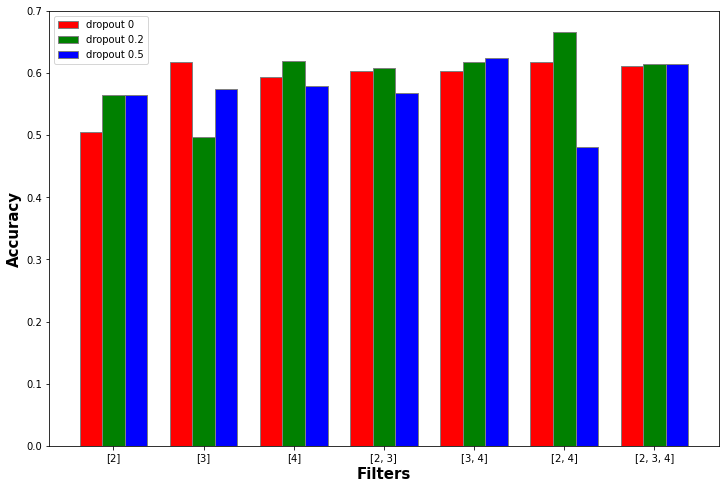

In [ ]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
br1 = np.arange(len(filters))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
plt.bar(br1, filters_for_dropout_0, color ='r', width = barWidth,
        edgecolor ='grey', label ='dropout 0')
plt.bar(br2, filters_for_dropout_02, color ='g', width = barWidth,
        edgecolor ='grey', label ='dropout 0.2')
plt.bar(br3, filters_for_dropout_05, color ='b', width = barWidth,
        edgecolor ='grey', label ='dropout 0.5')
 
plt.xlabel('Filters', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(filters))], filters)
plt.legend()
plt.show()

Результаты метрик получились не сильно разбросанными как это было в статье, при этом фильтры длины 2 и 3 показали результаты не хуже чем длины 1 (а в статье лучшие результаты были именно у фильтров длины 1). У нас же лучшие результаты получились при комбинации фильтра [2,4] и dropout 0.2. В целом почти со всеми фильтрами (кроме фильтра 3) dropout 0.2 показал наилучшие результаты. 
Попробуем теперь применить большее кол-во фильтров в CNN и изменим параметр memory dimension in LSTM.

In [ ]:
model = C_LSTM(len(word2id), max_len=600, filter_sizes=[2, 4],
               filters_num=300, memory_dim=300, dropout_rate=0.2, 
               dropout_input=False, dropout_lstm=True)
model = model.to(DEVICE)
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

epochs = 5
train_losses = []
train_accuracy = []
eval_losses = []
eval_accuracy = []

for epoch in range(epochs):
    print(f'\nstarting Epoch {epoch+1}')
    print('Training...')
    epoch_loss, epoch_metrics = train(model, optimizer, criterion, epoch)
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_metrics)
    print('\nEvaluating...')
    epoch_loss_eval, epoch_metrics_eval = evaluate(model, criterion)
    eval_losses.append(epoch_loss_eval)
    eval_accuracy.append(epoch_metrics_eval)          


starting Epoch 1
Training...


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6562300591633237, Train metric: 0.39622801542282104
Train loss: 1.6482793298260918, Train metric: 0.4016621708869934
Train loss: 1.6472673525755432, Train metric: 0.4049249291419983
Train loss: 1.6463246283860042, Train metric: 0.40668562054634094
Train loss: 1.6445804817923184, Train metric: 0.4093874990940094

Evaluating...
Val loss: 1.6259040321622575, Val metric: 0.42480215430259705
Val loss: 1.6401340961456299, Val metric: 0.4088577330112457
Val loss: 1.6376099983851116, Val metric: 0.4150264263153076
Val loss: 1.63722391639437, Val metric: 0.4140211045742035
Val loss: 1.6357744557516916, Val metric: 0.41660642623901367

starting Epoch 2
Training...


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.6470410412755505, Train metric: 0.40523725748062134
Train loss: 1.6414877649011284, Train metric: 0.41609686613082886
Train loss: 1.6296056728253419, Train metric: 0.4376252591609955
Train loss: 1.589242881742017, Train metric: 0.49332255125045776
Train loss: 1.559612277458454, Train metric: 0.5254786610603333

Evaluating...
Val loss: 1.4101537806647164, Val metric: 0.6788009405136108
Val loss: 1.434875556400844, Val metric: 0.6562873721122742
Val loss: 1.4341850961957658, Val metric: 0.6583410501480103
Val loss: 1.4306967939649309, Val metric: 0.6599054932594299
Val loss: 1.430614801815578, Val metric: 0.6622128486633301

starting Epoch 3
Training...


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.4320725695840244, Train metric: 0.6556276679039001
Train loss: 1.4245097945476402, Train metric: 0.6619626879692078
Train loss: 1.4212600705267369, Train metric: 0.6670229434967041
Train loss: 1.4212849962300267, Train metric: 0.6675045490264893
Train loss: 1.4210051955847904, Train metric: 0.6678420305252075

Evaluating...
Val loss: 1.3990146943501063, Val metric: 0.6883411407470703
Val loss: 1.4226609213011605, Val metric: 0.665864884853363
Val loss: 1.4225167887551444, Val metric: 0.6670811772346497
Val loss: 1.419537024838584, Val metric: 0.6676076054573059
Val loss: 1.41876311983381, Val metric: 0.6695329546928406

starting Epoch 4
Training...


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.408776094173563, Train metric: 0.680027425289154
Train loss: 1.4133583368926212, Train metric: 0.6717309355735779
Train loss: 1.4147291142365028, Train metric: 0.6714379787445068
Train loss: 1.417205561851633, Train metric: 0.6685486435890198
Train loss: 1.4162330684990718, Train metric: 0.6698803901672363

Evaluating...
Val loss: 1.4005051851272583, Val metric: 0.6835463643074036
Val loss: 1.4187604018620081, Val metric: 0.6719959378242493
Val loss: 1.4203642436436243, Val metric: 0.6694810390472412
Val loss: 1.4165688071932112, Val metric: 0.6708909869194031
Val loss: 1.415481093951634, Val metric: 0.6733265519142151

starting Epoch 5
Training...


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Train loss: 1.3986055933195969, Train metric: 0.6867908239364624
Train loss: 1.413571035039836, Train metric: 0.6727417707443237
Train loss: 1.4129783463204044, Train metric: 0.6715153455734253
Train loss: 1.4117338698485802, Train metric: 0.6738410592079163
Train loss: 1.4125147581100463, Train metric: 0.6737191081047058

Evaluating...
Val loss: 1.4027448722294398, Val metric: 0.675483226776123
Val loss: 1.4203684329986572, Val metric: 0.6656326055526733
Val loss: 1.4207372211274647, Val metric: 0.6640592217445374
Val loss: 1.4166083761623927, Val metric: 0.666254997253418
Val loss: 1.4160619565418788, Val metric: 0.6688755750656128


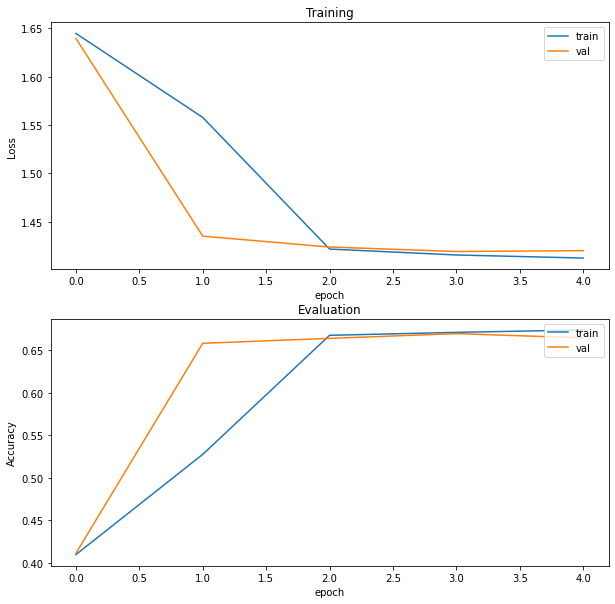

In [ ]:
plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.plot(train_losses)
plt.plot(eval_losses)
plt.title('Training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')


plt.subplot(212)
plt.plot(train_accuracy)
plt.plot(eval_accuracy)
plt.title('Evaluation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:
y_pred = []
y_true = []
for texts, y in val_iterator:   
    y_pred.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    y_true.extend(y.cpu().detach().numpy())
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       314
           1       0.00      0.00      0.00       156
           2       0.91      0.89      0.90      1810
           3       0.00      0.00      0.00       157
           4       0.00      0.00      0.00       892
           5       0.45      0.96      0.61      1368

    accuracy                           0.62      4697
   macro avg       0.23      0.31      0.25      4697
weighted avg       0.48      0.62      0.52      4697



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Стало чуть получше, но все равно результаты неутешительные...С какими параметрами у меня получилось улучшить модель:
- dropout 0.2
- filter_sizes [2,4]
- filters_num 300 
- memory_dim 300

В целом можно еще покрутить и другие параметры (я не меняла learning rate, функции активации). Я бы сказала, что наши данные сильно отличаются от тех данных, что использовались в статье, кроме того, наши данные плохо подходят для классификации в их первоначальном виде. Как можно было заметить из результатов выше, модель не справляется с классификацией малочисленных классов. 